# ivf timeseries

## prelude

In [1]:
import sys
from pathlib import Path
import itertools
import shutil
from datetime import datetime
import pandas as pd
import numpy as np
import scipy.stats as stats
from IPython.display import display_html, display, Markdown
# from scipy.optimize import curve_fit, minimize
from scipy import signal as s_signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for complex plot layouts
import inspect

def __plt_configure_fonts(font = "Arial"):
    plt.rcParams['svg.fonttype'] = 'none'
    assert (plt.rcParams["font.family"][0] == "sans-serif"), plt.rcParams["font.family"]
    fonts = plt.rcParams["font.sans-serif"]
    if fonts[0] != font:
        fonts.insert(0, font)
__plt_configure_fonts()

In [2]:
%run -i framework.py

ENV = dict(
    # use_columns=[
    #     'RER',
    #     'Feed',
    #     'DistD',
    #     'VO2(1)',
    #     'VCO2(1)',
    #     'Drink',
    #     # 'feed%mass',
    #     # 'feed%mass%dist*10^4'
    # ],
    data_columns = [cFeed, cDist, cRer, cO2, cCO2],
    data_samples_per_hour = 2,
    data_period = 24,
    group_colors = ['#40c080', '#f0a040', '#a040f0'],
    group_labels = ['K', '35', '37'],
    letters = plt_add_letters(letters=LETTERS_RU),
    figsave = plt_figsave_phony,
    groups = [0, 1, 2],
    lang = LANG_RU,
    test2 = test_mwu,
    cmp_do_trends = False,
    cmp2stars = cmp_to_stars_2_3gr,
    boxplot_stars = multi_boxplot_pairw_cmp_2_3gr,
    ts_x_ticks = np_arange(12, step=6, n_elements=19).astype(int),
    ts_avg_window = 6,
)
get_opts.default=ENV

ENV['data_animals']={0: [1, 2, 9, 10, 17, 18, 25, 26], 1: [3, 4, 5, 11, 12, 13, 19, 20, 21, 27, 28, 29], 2: [6, 7, 8, 14, 15, 16, 22, 23, 24, 30, 31, 32]}
# ^^^ this was originally deduced from the table activity_ts_v0. however, it's easier, if we put it here separately
animals_bad = [
    25, # g0, didn't eat for 2 light + 1 dark periods in the end
    # low RER when not eating
    13, # g1, didn't eat for the last light period
    # low RER last light period
    19, # g1, didn't eat for 2 light + 1 dark periods in the end
    # low RER last light period
    7, # g2, didn't eat for 1 dark + 1 light cycle in the end
    # normal RER. wtf?
    30, # g2, didn't eat for 2 light + 1dark period after 
    # the first dark period. 
    # abnormal RER 
#     31, #g2, almost no RER alteration
]
# "bad animals" were also originally deduced from timeseries plots & cosinor
ENV['data_animals'] = {k: [v for v in vs if v not in animals_bad] for k, vs in ENV.pop('data_animals').items()}

ENV['outd'] = Path("#=PHONY=#")
ENV_toggle_save = dct_with(ENV, dict(figsave=plt_figsave_svg_png_300dpi))

ENV

{'data_columns': ['Feed', 'DistD', 'RER', 'VO2(1)', 'VCO2(1)'],
 'data_samples_per_hour': 2,
 'data_period': 24,
 'group_colors': ['#40c080', '#f0a040', '#a040f0'],
 'group_labels': ['K', '35', '37'],
 'letters': <__main__.plt_add_letters at 0x7f359b2ccc20>,
 'figsave': <function __main__.plt_figsave_phony(path, fig)>,
 'groups': [0, 1, 2],
 'lang': 'RU',
 'test2': <function __main__.test_mwu(a, b, axis=None) -> float>,
 'cmp_do_trends': False,
 'cmp2stars': <function __main__.cmp_to_stars_2_3gr(data: list[numpy.ndarray], test_fn: <built-in function callable>, do_trend=False) -> list[str]>,
 'boxplot_stars': <function __main__.multi_boxplot_pairw_cmp_2_3gr(ax, stars: list[str], style=None)>,
 'ts_x_ticks': array([ 12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,  78,  84,
         90,  96, 102, 108, 114, 120]),
 'ts_avg_window': 6,
 'data_animals': {0: [1, 2, 9, 10, 17, 18, 26],
  1: [3, 4, 5, 11, 12, 20, 21, 27, 28, 29],
  2: [6, 8, 14, 15, 16, 22, 23, 24, 31, 32]},
 'outd': Posi

In [3]:
%run -i framework.py
%run -i framework_wb_v8.py
save_to, ckpts = ckpt_table_ckpt_v1(Path('..'))
save_to.mkdir(exist_ok=True)
tbls = {k: ckpt_load_or_create(v) for k, v in ckpts.items()}

hist_agg_side = ckpt_fn_ivf_histology_avg_by_animal_side_v1(ckpts['ivf_histology_v0'])
hist_agg = tbls['ivf_histology_avg_by_animal_v0']

sleep_total = ckpt_fn_ivf_sleep_total_v0("../data_src")
sleep_agg, sleep_ts = ckpt_fn_ivf_sleep_agg(sleep_total)

## wb v7 precursors

In [66]:
ENV.update({
        'group_colors': ['#a040f0', '#f0a040'],
        'group_labels': ['WT', 'IVF'],
        'groups': [0, 2],
        'lang': LANG_EN,
        'letters': plt_add_letters(LETTERS_EN),
    })

In [69]:
def plot_behav_averages_v5(activity_ts_v0, ivf_features_v0, axs=None, opts=None):
    activity_t = activity_ts_v0 # tbls['activity_ts_v0']
    feat_t = ivf_features_v0 # tbls['ivf_features_v0']
    
    ENV = get_opts(opts)
    outd = ENV['outd']
    data_animals = ENV['data_animals']
    groups = ENV['groups']
    
    if ENV['lang'] == LANG_RU:
        title = "!!!!!!!!!"
    elif ENV['lang'] == LANG_EN:
        title = {
            cFeed: "food consumed, g/h",
            "feed/mass": "food consumed, g /(h × kg)",
            cDist: "distance travelled, m/h",
            "dist/feed": "distance/food, m/g",
            cRer: "respiratory exchange ratio",
            cO2: "O$_2$ consumed, L /(h × kg)",
        }
    opts = {
        cFeed: dict(ylim = (0.15, 0.40), yticks = np_arange(0.15, 0.05, 5)), # feed
        "feed/mass": dict(ylim = (5.3, 7.3)), # feed/mass
        cDist: dict(ylim=(48, 140), yticks = np_arange(50, 20, 5)), # dist
        "dist/feed": dict(), # dist/feed
        cRer: dict(ylim=(0.93, 1.08), yticks = np_arange(0.95, 0.03, 5)), # rer
        cO2: dict(), 
    }
    if len(ENV['groups']) == 3:
        opts[1]['ylim']=(5, 8)
    ln_m_to_ln_cm = np.log(100)
    m_to_cm = 100
    assert np.isclose(np.log(5),np.log(5*m_to_cm) - ln_m_to_ln_cm, )
    log10_to_ln = np.log(10)
    assert np.isclose(np.log10(5)*log10_to_ln, np.log(5))
    
    no_fig = axs is None
    if no_fig:
        fig, axs = plt.subplots(3, 2, figsize=(c_A4_w, 3*3), sharex=True, gridspec_kw=dict(wspace=0.2, hspace=0.2))
        axs = axs.ravel()
    
    def summarize(col, animals):
            values = []
            for animal in animals:
                if col in ENV['data_columns']:
                    y = activity_t.loc[col, :, animal].Y.values
                    # y = t_animal(ts[col], animal).Y.values
                else: y = None

                if col == cDist:
                    ys = y.mean() /100 * 2
                elif col == cFeed:
                    ys = y.mean() * 2
                elif col == cRer:
                    ys = y.mean()
                elif col == cO2:
                    ys = y.mean()/1000
                elif col == "feed/mass": 
                    y = activity_t.loc[cFeed, :, animal].Y.values
                    # y = t_animal(ts[cFeed], animal).Y.values
                    mass = feat_t.loc[feat_t.animal_no == animal, 'Mass_13.05']
                    # mass = t02['Mass_13.05'][t02.animal_no == animal]
                    ys = y.mean() * 2 * (1000 / mass)
                # elif col == "dist/feed": # special case
                values.append(ys)
            return np.stack(values)
        
    gdatas = dict()
    for col in [cFeed, "feed/mass", cDist, cRer, cO2]:
        gdata = [summarize(col, data_animals[g]) for g in groups]
        gdatas[col] = gdata
    gdatas["dist/feed"] = [d/f for d, f in zip(gdatas[cDist], gdatas[cFeed])]
    for icol, col in enumerate([cO2, cRer, cFeed, cDist, "feed/mass", "dist/feed",]):
        gdata = gdatas[col]
        ax = axs[icol]
        boxplot_main(ax, gdata, ENV)
        ax.set(title=title[col], **opts[col])

    plt_delete_ticks(axs[:4])
    if no_fig:
        ENV['letters'](axs, (0.02, 0.90))
        ENV['figsave'](outd / f"{plotname()}.svg", fig)

plot_behav_averages_v5(tbls['activity_ts_v0'], tbls['ivf_features_v0'], opts=opts)

KeyError: 'activity_ts_v0'

In [179]:
def plot_behav_24h_2gr_3gr_v2(activity_ts_v0, opts=None):
    'is split into 2 figures'
    activity_t = activity_ts_v0
    ENV = get_opts(opts)
    outd = ENV['outd']
    groups = ENV['groups']
    data_animals = ENV['data_animals']
    figsave = ENV['figsave']
    letters = ENV['letters']
    if ENV['lang'] == LANG_RU:
        title = ["пройденный путь, м/ч", "съеденный корм, г/ч", "дыхательный коэффициент", "потребление O2, Л/кг/ч"]
    elif ENV['lang']==LANG_EN:
        title = ["O$_2$ consumed, L /(h × kg)", "respiratory exchange coefficient",
                 "food consumed, g/h", "distance travelled, m/h", ]
    colors = ENV['group_colors']
    labels = ENV['group_labels']
    if len(groups) == 3:
        linestyles, markers = ["-", "--", ":"], ["o", "^", "s"]
    elif len(groups) == 2:
        linestyles, markers = [None]*3, [None]*3
    else: raise ValueError(f"{len(groups)=}")
        
    plot_cols = [cO2, cRer, cFeed, cDist]
    X_TICKS = np_arange(0, 6, 5).astype(int)
    x = np.arange(0, 24) + 1
    
    fig0, axs0 = plt.subplots(2, 1, figsize=(c_A4_w-1, (c_A4_h-2)/2), layout="compressed")#gridspec_kw=dict(hspace=0.27))
    axs0 = axs0.ravel()
    fig1, axs1 = plt.subplots(2, 1, figsize=(c_A4_w-1, (c_A4_h-2)/2), layout="compressed")
    axs1 = axs1.ravel()
    axs = np.r_[axs0, axs1]
    
    for ax, col in zip(axs, plot_cols):
        # aggregate data
        accum1 = []
        # t = ts[col]
        for group in groups:
            accum2 = []
            for animal in data_animals[group]:
                ti = activity_t.loc[col, group, animal]
                y = ti.Y.values
                # compensate for 2 samples / h
                # RER is not compensated because it's a "flow" measure, while food & distance are "stock" measures
                if col == cDist:
                    y = y / 100 * 2
                elif col == cO2:
                    y = y / 1000 * 2
                elif col == cFeed:
                    y = y * 2
                y_p = nonparametric.periodic_avg(y, 48)
                assert len(y_p) == 48
                y_h = nonparametric.binned_avg(y_p, 2)
                assert len(y_h) == 24
                roll = 16
                y_r = np.roll(y_h, roll)
                assert y_r[roll] == y_h[0], np.array(list(zip(range(25), y_h, y_r)))
                accum2.append(y_r)
            accum1.append(accum2)
        # ---------
        gdata = [np.stack(g, axis=-1) for g in accum1]
        del accum1, accum2
        
        
        ms = np.stack([g.mean(axis=-1,) for g in gdata])
        stes = np.stack([g.std(axis=-1)/ np.sqrt(g.shape[-1]) for g in gdata])
        
#         mwus = stats.mannwhitneyu(grps[0], grps[1], axis=-1).pvalue
#         plot_data[col] = [ms, stes, mwus]
        for m, ste, c, ls, mark, lbl in zip(ms, stes, colors, linestyles, markers, labels):
            ax.plot(x, m, c=c, ls=ls, marker=mark, markersize=3, label=lbl)
            ax.fill_between(x, m-ste, m+ste, color=c, alpha=0.2)
            ax.set_xticks([1, 6, 12, 18, 24], [1, 6, 12, 18, 24])
            ax.set_xticks(np.arange(24), minor=True)
            ax.set_xlim(1, 24)
        
        ax.axvspan(0.0+1, 2.5+1, color="k", alpha=0.08)
        ax.axvspan(15.5+1, 23.0+1, color="k", alpha=0.08)
        
        # plot pvalues
        top = (ms+stes).max(axis=0)
        span = top.max() - (ms-stes).min()
        ann1 = top + 0.12*span # line on which pvalues rest
        ann2 = ann1 + 0.12*span
        ann3 = ann2 + 0.12*span
        if len(groups) == 2:
            p = test_t_ind(gdata[0], gdata[1], axis=-1)
            l1 = (p<=0.05) 
            l2 = (p<=0.01)
            l3 = p<=0.001
            for l, ann in [(l1, ann1), (l2, ann2), (l3, ann3)]:
                ax.plot(x[l], ann[l], c="k", marker="*", ls="none")
        elif len(groups) == 3:
            for dat, c, ann in zip(gdata[1:], colors[1:], [ann1, ann2]):
                p = test_t_ind(gdata[0], dat, axis=-1)
                l1 = (p<=0.05) & (p>0.01)
                l2 = (p<=0.01) & (p>0.001)
                l3 = p<=0.001
    #             ax.plot(x, ann, lw=0.3, c="k", alpha=0.1)
                ax.plot(x[l1], ann[l1], c=c, marker="$1$", ls="none")
                ax.plot(x[l2], ann[l2], c=c, marker="$2$", ls="none")
                ax.plot(x[l3], ann[l3], c=c, marker="$3$", ls="none")
        
        # pvalue
        y_pval = np.max(np.stack(ms, axis=-1), axis=-1)
        y_scale = (y_pval.max() - y_pval.min())
#         for p, coef in ((0.05, .2), (0.01, .3), (0.001, .4)):  
#             ax.plot(x[mwus<p], coef*y_scale+y_pval[mwus<p], ls="none", color="k", marker="*", markersize=5)

    for i in range(4):
        # axs[i].set_title(title[i])
        axs[i].set_ylabel(title[i])
    # axs[2].set_ylim((0.85, 1.05))
    # axs[0].legend(loc="upper left", facecolor="none", edgecolor="none", ncols=3)
    for i in [0, 2]:
        axs[i].legend(loc=(0.0, 0.85), facecolor="none", edgecolor="none", ncols=3)

    for axss in [axs0, axs1]:
        letters(axss, (0.01, 1.03))
    figsave(outd / f"{plotname()}-main.svg", fig0)
    figsave(outd / f"{plotname()}-supp.svg", fig1)
    
plot_behav_24h_2gr_3gr_v2(tbls['activity_ts_v0'], opts=None)

KeyError: 'activity_ts_v0'

phony save #=PHONY=#/cosinor_params_v4-main.svg
phony save #=PHONY=#/cosinor_params_v4-supp.svg


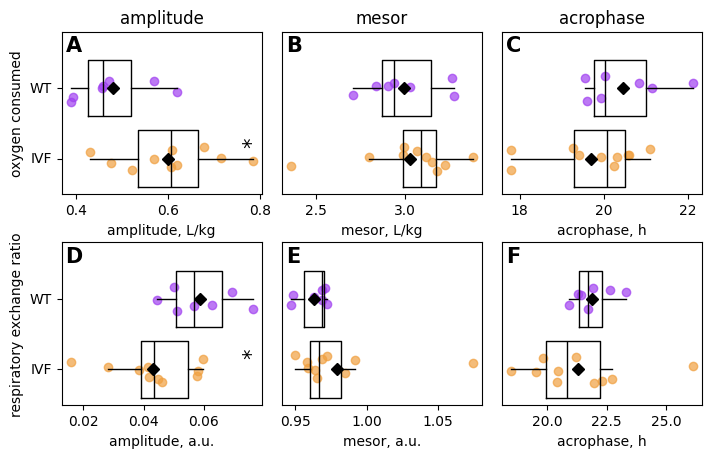

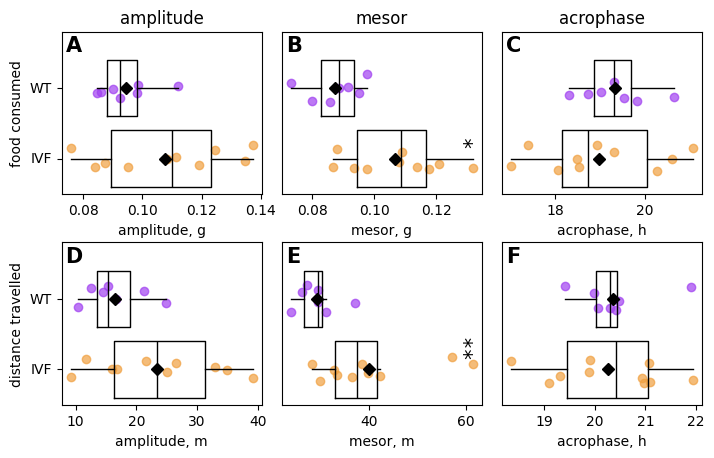

In [41]:

def plot_cosinor_params_v4(ivf_ts_cosinor_v0, opts=None):
    ENV = get_opts(opts)
    cosinor_t = ivf_ts_cosinor_v0 #tbls["ivf_ts_cosinor_v0"]
    
    def mb2(
        ax, 
        group_data: list[np.ndarray],
        labels: list[str]= None,
        colors: list = None,
        style_kw = None
    ):
        colors = iter(colors)
        style_kw = plt_multi_boxplot.boxplot_kw if style_kw is None else style_kw
        scatter_kw = plt_multi_boxplot.scatter_kw
        for i, data in enumerate(group_data):
            x_pseudo = i + np.random.uniform(-0.2, 0.2, len(data))
            ax.boxplot(data, positions=[i, ], manage_ticks=False, vert=False, **style_kw)
            ax.scatter(data, x_pseudo, color=next(colors), **scatter_kw)
        if labels:
            ax.set_yticks(np.arange(len(labels)), labels, verticalalignment="center") # rotation=90,

    def cmp(
        ax, stars: list[str], 
        style=None,
    ):
        style = style or _multi_boxplot_pairw_cmp_2_3gr_default_style
        style = dict(rotation=90, **style)
        if len(stars) == 1:
            p01 = stars[0]
            if p01:
                ax.annotate(p01, (0.9, 2.5/8), xycoords="axes fraction", **style)
        elif len(stars) == 3:
            p01, p02, p12 = stars
        #     _s = dict( fontfamily='DejaVu Sans') # 'ᵀ' sub/superscripts unfortunately require careful font selection
            if p01:
                ax.annotate(p01, (0.9, 6/12), xycoords="axes fraction", **style)
            if p02:
                ax.annotate(p02, (0.9, 2/12), xycoords="axes fraction", **style)
            if p12:
                ax.annotate(p12, (0.80, 2/12), xycoords="axes fraction", **style)
        else: raise ValueError(f"{len(stars)=}")
            
    def bm2(ax, gdata, **kw):
        'macro-like, it just reduces number of lines drammatically'
        mb2(ax, gdata[::-1], ENV['group_labels'][::-1], ENV['group_colors'][::-1])
        stars = ENV['cmp2stars'](gdata, ENV['test2'], ENV['cmp_do_trends'])
        cmp(ax, stars)

    
    save_to = ENV['outd'] / f"{plotname()}.svg"
    data_animals = ENV['data_animals']
    groups = ENV['groups']
    if ENV['lang']==LANG_RU:
        letters = LETTERS_RU
        title = ["пройденный путь", "съеденный корм", "дыхательный коэф."]
        ylabel = [
            ["амплитуда, log10(м)", "амплитуда, log10(г)", "амплитуда, у.е."],
            ["мезор, log10(m)", "мезор, log10(г)", "мезор, у.е."],
            "акрофаза, ч",
        ]
    elif ENV['lang']==LANG_EN:
        letters = LETTERS_EN
        title = ["distance travelled", "food consumed", "respiratory exchange ratio"]
        ylabel = [
            ["amplitude, log10(m)", "amplitude, log10(g)", "amplitude, a.u."],
            ["mesor, log10(m)", "mesor, log10(g)", "mesor, a.u."],
            "acrophase, h",
        ]
    letters = plt_add_letters(ENV['letters'])
    # conversion coefs
    ln_m_to_ln_cm = np.log(100)
    m_to_cm = 100
    assert np.isclose(
        np.log(5),
        np.log(5*m_to_cm) - ln_m_to_ln_cm, 
    )
    log10_to_ln = np.log(10)
    assert np.isclose(np.log10(5)*log10_to_ln, np.log(5))

    fig0, axs0 = plt.subplots(2, 3, figsize=(c_A4_w, (c_A4_h-2)/2), sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.3))
    fig1, axs1 = plt.subplots(2, 3, figsize=(c_A4_w, (c_A4_h-2)/2), sharey=True, gridspec_kw=dict(wspace=0.1, hspace=0.3))
    axs = np.concatenate([axs0, axs1])
    
    for icol, col in enumerate([cO2, cRer, cFeed, cDist]):
        if col in [cRer, cO2]:
            model= N24
            modeln = 'N24'
        else: 
            model = P24
            modeln = 'P24'
        gdatas = [cosinor_t.loc[modeln, col, g, data_animals[g]] for g in groups]
            
        for irow, row in enumerate(['amplitude', 'mesor', 'acrophase_h']):
            gdata = [d[row].values for d in gdatas]
#             group_data = {k: v[row].values for k, v in gb.items()}
            if row == 'mesor' and col in [cFeed, cDist]:
                gdata = [P24.link(d['mesor'].values) for d in gdatas]
            elif row == 'amplitude' and col in [cFeed, cDist]:
                gdata = []
                for d in gdatas:
                    # pts = np.r_[d['acrophase_h'].values, d['acrophase_h'].values + P24.period / 2]
                    d1 = (
                        cosinor.predict(d['acrophase_h'].values, **d, link = P24.link) -
                        cosinor.predict(d['acrophase_h'].values + P24.period / 2, **d, link=P24.link)
                    ) / 2
                    gdata.append(d1)
            if row in ['amplitude', 'mesor']: # adjust y-values, but not x-values (acrophase)
                if col == cO2:
                    gdata = [d/1000 for d in gdata] # ml to l
                elif col == cDist:
                    gdata = [d/100 for d in gdata] # cm to m
                
#             mwu = stats.mannwhitneyu(group_data["WT"], group_data["IVF"])
            ax = axs[icol, irow, ]
            bm2(ax, gdata)
            ax.set_ylim(-0.5, 1.8 if len(ENV['groups']) == 2 else 2.8)
            if irow == 0:
                ax.set_ylabel(col)
    plt_delete_ticks(axs[:, 1:].ravel(), 'y')
    for i in [0, 2]:
        axs[i, 0].set_title("amplitude")
        axs[i, 1].set_title("mesor")
        axs[i, 2].set_title("acrophase")
    i = 3
    axs[i, 0].set_ylabel("distance travelled")
    axs[i, 0].set_xlabel("amplitude, m")
    axs[i, 1].set_xlabel("mesor, m")
    axs[i, 2].set_xlabel("acrophase, h")
    i = 2
    axs[i, 0].set_ylabel("food consumed")
    axs[i, 0].set_xlabel("amplitude, g")
    axs[i, 1].set_xlabel("mesor, g")
    axs[i, 2].set_xlabel("acrophase, h")
    i = 1
    axs[i, 0].set_ylabel("respiratory exchange ratio")
    axs[i, 0].set_xlabel("amplitude, a.u.")
    # axs[2, 0].set_xlim(0.01, 0.08)
    axs[i, 1].set_xlabel("mesor, a.u.")
    # axs[2, 1].set_xlim(0.92, 1.08)
    axs[i, 2].set_xlabel("acrophase, h")
    i = 0
    axs[i, 0].set_ylabel("oxygen consumed")
    axs[i, 0].set_xlabel("amplitude, L/kg")
    # axs[3, 0].set_xlim(0.3, 0.9)
    axs[i, 1].set_xlabel("mesor, L/kg")
    # axs[3, 1].set_xlim(2.2, 3.8)
    axs[i, 2].set_xlabel("acrophase, h")
    ENV['letters'](axs0, (0.02, 0.88))
    ENV['letters'](axs1, (0.02, 0.88))
    ENV['figsave'](ENV['outd'] / f"{plotname()}-main.svg", fig0)
    ENV['figsave'](ENV['outd'] / f"{plotname()}-supp.svg", fig1)
    
plot_cosinor_params_v4(tbls['ivf_ts_cosinor_v0'], opts=None)

phony save #=PHONY=#/behav_day_night_v4-main.svg
phony save #=PHONY=#/behav_day_night_v4-supp.svg


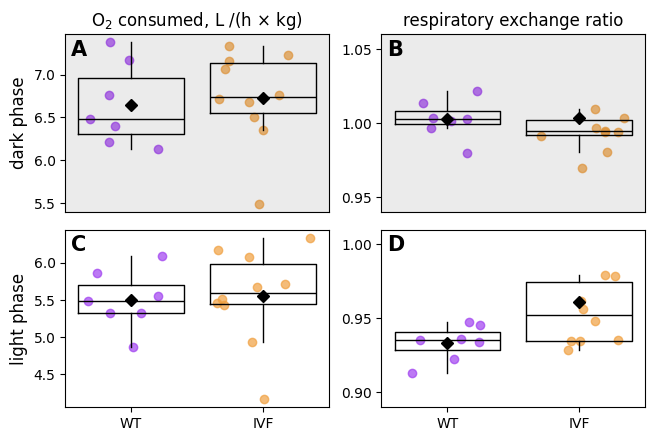

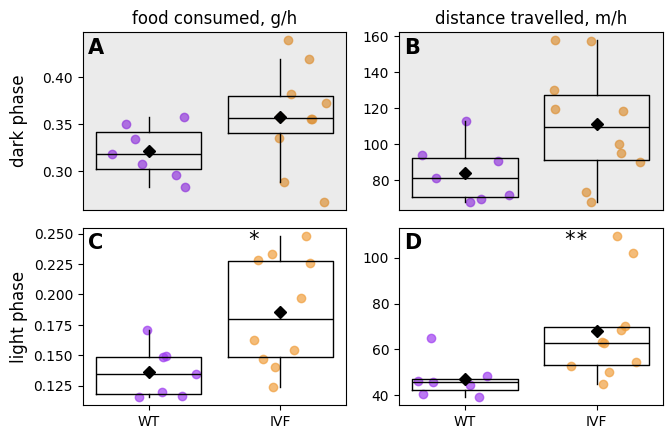

In [42]:

def plot_behav_day_night_v4(activity_ts_v0, opts=None):
    ENV = get_opts(opts)
    activity_t = activity_ts_v0 #tbls["activity_ts_v0"]
    plot_cols = [cO2, cRer, cFeed, cDist,]
    save_to = ENV['outd'] / f"{plotname()} {'_'.join(plot_cols)}.svg"
    groups = ENV['groups']
    data_animals = ENV['data_animals']
    figsave = ENV['figsave']
    letters = ENV['letters']
    if ENV['lang'] == LANG_RU:
        title = ["пройденный путь, м/ч", "съеденный корм, г/ч", "дыхательный коэф."]
        ylabel = ["темная фаза", "светлая фаза"]
    elif ENV['lang'] == LANG_EN:
        title = ["distance travelled, m/h", "food consumed, g/h", "respiratory exchange ratio"]
        ylabel = ["dark phase", "light phase"]

    kw = dict(figsize=(c_A4_w-20*c_mm2in, (c_A4_h-2)/2), sharex=True, gridspec_kw=dict(hspace=0.1, wspace=0.2),)
    fig0, axs0 = plt.subplots(2, 2, **kw)
    fig1, axs1 = plt.subplots(2, 2, **kw)
    axs0 = axs0.T; axs1 = axs1.T;
    axs = np.concatenate([axs0, axs1])
    for ax_pair, col in zip(axs, plot_cols):
        accum1 = []
        for group in groups:
            accum2 = []
            for animal in data_animals[group]:
                ti = activity_t.loc[col, group, animal]
                y = ti.Y.values           
                if col == cDist:
                    y = y / 100 * 2
                elif col == cFeed:
                    y = y * 2
                elif col == cO2:
                    y = y / 1000 * 2
                y_p = nonparametric.periodic_avg(y, 48)
                assert len(y_p) == 48
                y_h = nonparametric.binned_avg(y_p, 2)
                assert len(y_h) == 24
                roll = 16
                y_r = np.roll(y_h, roll)
                assert y_r[roll] == y_h[0], np.array(list(zip(range(25), y_h, y_r)))
                accum2.append(y_r)
            accum1.append(accum2)
        gdata = [np.stack(g, axis=-1) for g in accum1]
        del accum1, accum2
        # ---------
        # average across dark/light periods
        dark = [(d[:3].sum(axis=0) + d[17:].sum(axis=0))/10 for d in gdata]
        light = [d[3:17].mean(axis=0) for d in gdata]
        # plot dark
        ax = ax_pair[0]
        boxplot_main(ax, dark, ENV)
        ax.axvspan(-1, 4, color="k", alpha=0.08)
        ax.set_xlim((-0.5, len(groups)-0.5))
        # plot light
        ax = ax_pair[1]
        boxplot_main(ax, light, ENV)
    axs0 = axs0.T; axs1 = axs1.T;
    for axss in [axs0, axs1]:
        axss[0, 0].set_ylabel("dark phase", fontsize=12)
        axss[1, 0].set_ylabel("light phase", fontsize=12)
    # axs0[0, 0].set_title("O2 consumption, L/kg/h")
    axs0[0, 0].set_title("O$_2$ consumed, L /(h × kg)")
    axs0[0, 1].set_title("respiratory exchange ratio")
    axs0[0, 1].set_yticks(np_arange(0.95, 0.05, 3))
    axs0[0, 1].set_ylim(0.94, 1.06)
    axs0[1, 1].set_yticks(np_arange(0.90, 0.05, 3))
    axs0[1, 1].set_ylim(0.89, 1.01)
    # axs0[1, 1].set_ylim(0.90, 1.00)
    
    axs1[0, 0].set_title("food consumed, g/h")
    axs1[0, 1].set_title("distance travelled, m/h")
    
    fig0.align_ylabels(axs0[:, 0])
    fig1.align_ylabels(axs1[:, 0])
    plt_delete_ticks(axs0[:-1].ravel(), 'x')
    plt_delete_ticks(axs1[:-1].ravel(), 'x')
    # print(axs.shape)
    letters(axs0, (0.02, 0.88))
    letters(axs1, (0.02, 0.88))
    figsave(ENV['outd'] / f"{plotname()}-main.svg", fig0)
    figsave(ENV['outd'] / f"{plotname()}-supp.svg", fig1)

plot_behav_day_night_v4(tbls['activity_ts_v0'], opts=None)

## wb v7

In [43]:
%run -i ./framework.py
def plotwb_behav_ts_2gr_v7(reset_dir=False):
    # TODO: FIX COSINOR PLOT (units for vo2, fix y axis)
    # TODO: check units everywhere
    fn = get_caller()
    d = fn.__name__.removeprefix("plotwb_")
    outd = Path(f"../workbooks/{d}").resolve()
    if reset_dir: shutil.rmtree(outd)
    outd.mkdir(exist_ok=True, parents=True)
    opts = {
        'group_colors': ['#a040f0', '#f0a040'],
        'group_labels': ['WT', 'IVF'],
        'groups': [0, 2],
        'lang': LANG_EN,
        'letters': plt_add_letters(LETTERS_EN),
        'outd': outd,
        'figsave': plt_figsave_svg_png_300dpi,
    }
    opts = dct_diff_update(opts, ENV)
    plot_mass_glucose_v0(tbls['ivf_features_v0'], opts=opts)
    plot_behav_averages_v5(tbls['activity_ts_v0'], tbls['ivf_features_v0'], opts=opts)
    plot_behav_24h_2gr_3gr_v2(tbls['activity_ts_v0'], opts=opts)
    plot_hippocampus_startle_v0(tbls['ivf_features_v0'], opts=opts)
    # plot_cosinor_example_v0(tbls['ivf_ts_cosinor_v0'], tbls['activity_ts_v0'], opts=opts)
    plot_cosinor_params_v4(tbls['ivf_ts_cosinor_v0'], opts=opts)
    plot_behav_day_night_v4(tbls['activity_ts_v0'], opts=opts)
    plot_sleep_agg_dark_light_v1(sleep_agg, sleep_ts, opts=opts)
    print("Done!\a")
plotwb_behav_ts_2gr_v7(reset_dir=1)

/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/mass_glucose_v0.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/behav_averages_v5.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/behav_24h_2gr_3gr_v2-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/behav_24h_2gr_3gr_v2-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/hippocampus_startle_v0.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/cosinor_params_v4-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/cosinor_params_v4-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/behav_day_night_v4-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/behav_day_night_v4-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v7/sleep_agg_dark_light_v1.svg
Done!


In [115]:
t = tbls['nonparametric_ts_sum_v0'].set_index(['behav', 'group', 'animal'])
_tget = lambda behav, metric: [t.loc[(behav, 0, slice(None)), metric].values, t.loc[(behav, 2,  slice(None)), metric].values]

fig, axs = plt.subplots(2, 2, layout='compressed')
axs = axs.ravel()
for ax, col in zip(axs, [cO2, cRer, cFeed, cDist]):
    boxplot_main(ax, _tget(col, 'IV'), ENV)
    ax.set_title(col)
fig.suptitle('IV')
plt_figsave_svg_png_600dpi(Path('../workbooks/misc/iv_draft.svg'), fig)

fig, axs = plt.subplots(2, 2, layout='compressed')
axs = axs.ravel()
for ax, col in zip(axs, [cO2, cRer, cFeed, cDist]):
    boxplot_main(ax, _tget(col, 'DFA1'), ENV)
    ax.set_title(col)
fig.suptitle('DFA')

plt_figsave_svg_png_600dpi(Path('../workbooks/misc/dfa_draft.svg'), fig)

../workbooks/misc/iv_draft.svg
../workbooks/misc/dfa_draft.svg


## energy stuff

## wb v8 prep

In [4]:
ENV.update({
    'group_colors': ['#a040f0', '#f0a040'],
    'group_labels': ['WT', 'IVF'],
    'groups': [0, 2],
    'lang': LANG_EN,
    'letters': plt_add_letters(LETTERS_EN),
    'outd': Path("/home/data/lab/ivf2023/workbooks/temp"),
    # 'figsave': plt_figsave_svg,
    'figsave': plt_figsave_phony,
        # 'figsave': plt_figsave_svg_png_300dpi,

})
ENV.update(
    axw=2.5,
    axh=3,
    gridkw=dict(wspace=0.1),
    letpos=(0.02, 0.92),
    do_axlabels=True,
)

## wb v8

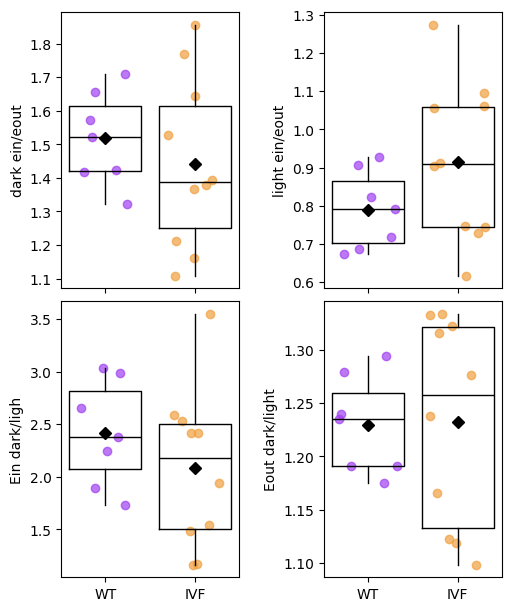

In [15]:
def __():
    t = prep_get_behav_24(tbls['activity_ts_v1'])
    # t.to_csv("../checkpoints/table_ckpt_v1/df24.csv", sep="\t")
    dark = t[[17, 18, 19, 20, 21, 22, 23, 0, 1, 2]].mean(axis='columns')
    light = t[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,]].mean(axis="columns")
    # display(dark)
    d = dark.loc['Ein'] / dark.loc['Eout']
    l = light.loc['Ein'] / light.loc['Eout']
    groups = ENV['groups']
    data_animals = ENV['data_animals']
    fig, axs = plt.subplots(2, 2, figsize = (bxp_w*2, bxp_h*2), gridspec_kw=bxp_gskw, sharex=True, layout="compressed")
    axs = axs.ravel()
    ax  = axs[0]
    boxplot_main(ax, [d.loc[g, data_animals[g]] for g in groups] , ENV)
    ax.set_ylabel("dark ein/eout")
    ax = axs[1]
    boxplot_main(ax, [l.loc[g, data_animals[g]] for g in groups], ENV)
    ax.set_ylabel("light ein/eout")
    inp = dark.loc['Ein'] / light.loc['Ein'] 
    out = dark.loc['Eout'] / light.loc['Eout']
    ax  = axs[2]
    boxplot_main(ax, [inp.loc[g, data_animals[g]] for g in groups] , ENV)
    ax.set_ylabel("Ein dark/ligh")
    ax = axs[3]
    boxplot_main(ax, [out.loc[g, data_animals[g]] for g in groups], ENV)
    ax.set_ylabel("Eout dark/light")
__()

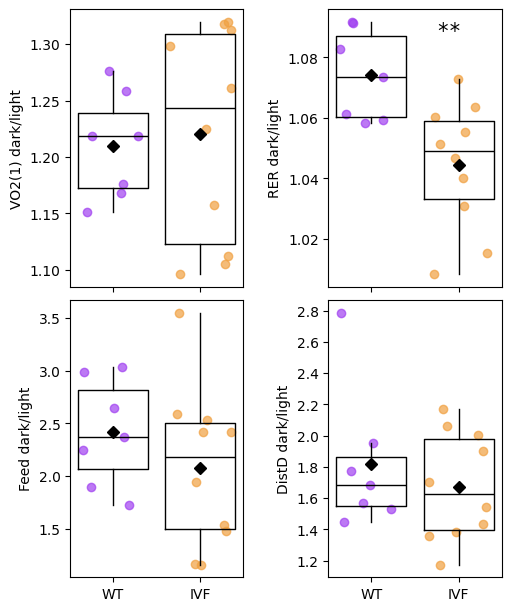

In [17]:
def __():
    t = prep_get_behav_24(tbls['activity_ts_v1'])
    # t.to_csv("../checkpoints/table_ckpt_v1/df24.csv", sep="\t")
    dark = t[[17, 18, 19, 20, 21, 22, 23, 0, 1, 2]].mean(axis='columns')
    light = t[[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,]].mean(axis="columns")
    # display(dark)
    groups = ENV['groups']
    data_animals = ENV['data_animals']

    fig, axs = plt.subplots(2, 2, figsize = (bxp_w*2, bxp_h*2), gridspec_kw=bxp_gskw, sharex=True, layout="compressed")
    axs = axs.ravel()
    for i, behav in enumerate([cO2, cRer, cFeed, cDist,]):  
        d = dark.loc[behav] / light.loc[behav]
        ax = axs[i]
        boxplot_main(ax, [d.loc[g, data_animals[g]] for g in groups], ENV)
        ax.set_ylabel(f"{behav} dark/light")
__()

In [4]:
%run -i ./framework.py
%run -i ./framework_wb_v8.py

_, ckpts = ckpt_table_ckpt_v1(Path(".."))
# shutil.rmtree(_); _.mkdir()
tbls = {k: ckpt_load_or_create(v) for k, v in ckpts.items()}

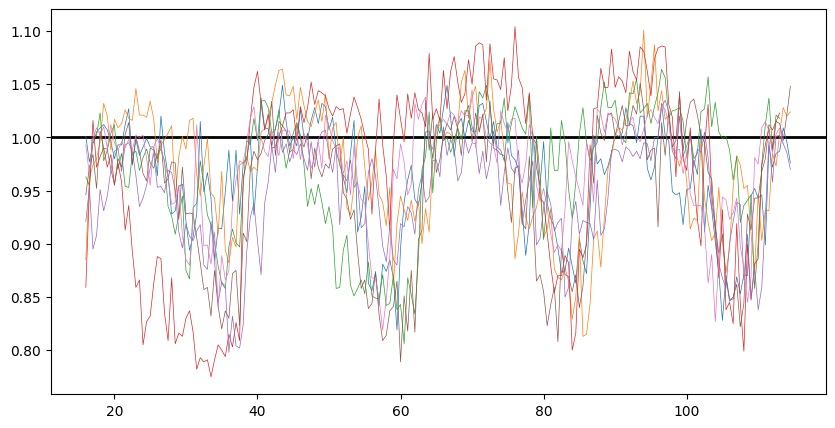

In [5]:
def __():
    t = tbls['activity_ts_v1']
    tgs = [t.loc[cRer, g, ENV['data_animals'][g]] for g in [0, 1, 2]]
    plt.figure(figsize=(10, 5))
    plt.axhline(1.0, c='k', lw=2)
    for i in [0]:
        tg = tgs[i].pivot_table(index="X", columns="ANIMAL", values="Y")
        plt.plot(tg.index, tg, lw=0.5,)# c=ENV['group_colors'][i], label=ENV['group_labels'][i], )
    
__()

In [90]:
def _rerpeaks():
    t = tbls['activity_ts_v1']
    ENV= get_opts()
    ENV = dct_diff_update(dict(
        groups = [0, 1, 2], 
        group_colors = ['#40c080', '#f0a040', '#a040f0'], 
        group_labels = ['C', '35', '37'],
    ), ENV)
    outd = ENV['outd']/plotname()
    outd.mkdir(exist_ok=True, parents=True)

    tgs = [t.loc[cRer, g, ENV['data_animals'][g]] for g in ENV['groups']]
    plt.figure(figsize=(10, 5))
    gdatas = {'mean': [], 'median': [], 'q4': [], 'count': [], 'max': []}
    for i, g in enumerate(ENV['groups']):
        tg = tgs[g].pivot_table(index="X", columns="ANIMAL", values="Y")
        tg -= 1.0
        tg[~(tg > 0)] = np.nan # includes Nan
        plt.plot(tg.index, tg, lw=0.5)
        tga = tg.values
        print(tga.shape)
        gdatas['mean'].append(np.nanmean(tga, axis=0)*2)
        gdatas['median'].append(np.nanmedian(tga, axis=0))
        gdatas['q4'].append(np.nanquantile(tga, 0.75, axis=0))
        gdatas['count'].append(np.sum(tga == tga, axis=0)/2)
        gdatas['max'].append(np.nanmax(tga, axis=0))
        plt.plot(tg.index, tg, lw=0.5, c=ENV['group_colors'][i],)
        plt.plot([], [], lw=2, c=ENV['group_colors'][i], label=ENV['group_labels'][i],)
    plt.legend()
    ENV['figsave'](outd / 'ts.svg', plt.gcf())
    
    for k, gdata in gdatas.items():
        plt.figure(figsize=(ENV['axw'], ENV['axh']))
        ax = plt.gca()
        boxplot_main(ax, gdata, ENV)
        ax.set_ylabel(k, fontsize=12)
        ENV['figsave'](outd/f'{k}.svg', plt.gcf())
_rerpeaks()

(198, 7)
(198, 10)
(198, 10)
../workbooks/today/_rerpeaks/ts.svg
../workbooks/today/_rerpeaks/mean.svg
../workbooks/today/_rerpeaks/median.svg
../workbooks/today/_rerpeaks/q4.svg
../workbooks/today/_rerpeaks/count.svg
../workbooks/today/_rerpeaks/max.svg


In [86]:
ENV['group_colors']

['#a040f0', '#f0a040']

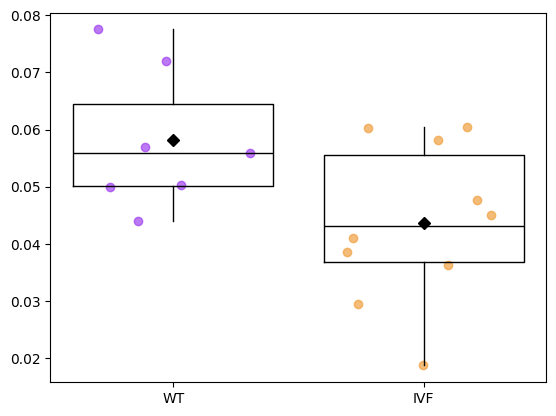

In [328]:
_ = tbls['nonparametric_ts_sum_v0'].set_index(['behav', 'group', 'animal'])
gdata = [_.loc[(cRer, g, ENV['data_animals'][g]), 'RA'] for g in ENV['groups']]
boxplot_main(plt.gca(), gdata, ENV)

In [22]:
%run -i ./framework_wb_v8.py

def plotwb_behav_ts_2gr_v8():
    # TODO: FIX COSINOR PLOT (units for vo2, fix y axis)
    # TODO: check units everywhere
    fn = get_caller()
    d = fn.__name__.removeprefix("plotwb_")
    outd = Path(f"../workbooks/{d}").resolve()
    outd.mkdir(exist_ok=True, parents=True)
    opts = {
        'group_colors': ['#a040f0', '#f0a040'],
        'group_labels': ['WT', 'IVF'],
        'groups': [0, 2],
        'lang': LANG_EN,
        'letters': plt_add_letters(LETTERS_EN),
        'outd': outd,
        'figsave': plt_figsave_svg_png_300dpi,
    }
    opts = dct_diff_update(opts, ENV)

    save_to, ckpts = ckpt_table_ckpt_v1(Path('..'))
    save_to.mkdir(exist_ok=True)
    tbls = {k: ckpt_load_or_create(v) for k, v in ckpts.items()}
    
    # hist_agg_side = ckpt_fn_ivf_histology_avg_by_animal_side_v1(ckpts['ivf_histology_v0'])
    # hist_agg = tbls['ivf_histology_avg_by_animal_v0']
    # sleep_total = ckpt_fn_ivf_sleep_total_v0("../data_src")
    # sleep_agg, sleep_ts = ckpt_fn_ivf_sleep_agg(sleep_total)
    
    plot_mass_glucose_v1(tbls['ivf_features_v0'], opts=opts) # DONE
    plot_behav_averages_v6(tbls['activity_ts_v1'], tbls['ivf_features_v0'], opts=opts) # DONE
    plot_behav_24h_2gr_3gr_v4(tbls['activity_ts_v1'], opts=opts) # DONE
    plot_hippocampus_startle_v1(tbls['ivf_features_v0'], opts=opts) # DONE
    # plot_cosinor_example_v0(tbls['ivf_ts_cosinor_v0'], tbls['activity_ts_v0'], opts=opts)
    plot_cosinor_params_v5(tbls['ivf_ts_cosinor_v0'], opts=opts) # DONE
    plot_behav_day_night_v5(tbls['activity_ts_v1'], opts=opts) # DONE
    
    # plot_sleep_agg_dark_light_v1(sleep_agg, sleep_ts, opts=opts) # todo
    
    plot_energy_balance_individ_v0(tbls['activity_ts_v1'], opts=opts) # DONE
    plot_energy_summary_v0(tbls['activity_ts_v1'], opts=opts) # DONE
    plot_energy_nonparametrics_v0(tbls['nonparametric_ts_sum_v0'], opts=opts) # DONE
    plot_cosinor_params_v5_energy(tbls['ivf_ts_cosinor_v0'], opts=opts) # DONE
    plot_energy_acrophase_difference_v0(tbls['ivf_ts_cosinor_v0'], opts=opts) # DONE
    plot_behav_24h_2gr_3gr_v3_energy(tbls['activity_ts_v1'], opts=opts) # DONE
    plot_behav_day_night_v5_energy(tbls['activity_ts_v1'], opts=opts) # DONE
    
    print("Done!\a")
plotwb_behav_ts_2gr_v8()

/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/mass_glucose_v1.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/behav_averages_v6.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/behav_24h_2gr_3gr_v4-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/behav_24h_2gr_3gr_v4-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/hippocampus_startle_v1.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/cosinor_params_v5-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/cosinor_params_v5-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/behav_day_night_v5-main.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/behav_day_night_v5-supp.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/energy_balance_individ_v0.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/energy_summary_v0.svg
/home/realdata/lab/ivf2023/workbooks/behav_ts_2gr_v8/energy_nonparametrics_v0.svg
/home/realdata/lab/ivf2023/workbooks/behav_t

## post wb v8

In [250]:
t = ckpt_load_or_create( tbls['ivf_histology_v0'])
t

snap_id  animal  group  p1  p2  region   side  area_mean   area_sum  \
0      26611     01l      2   1 NaN  cortex   left  68.154721  20241.952   
1      26612     01l      2   1 NaN  cortex   left  71.384814  22985.910   
2      26613     01l      2   1 NaN  cortex   left  72.296140  16555.816   
3      26614     01l      2   1 NaN  cortex   left  71.264404  16248.284   
4      26615     01l      2   1 NaN  cortex   left  66.884975  23677.281   
..       ...     ...    ...  ..  ..     ...    ...        ...        ...   
854    26499  23null      2   3 NaN  cortex  right  45.067644   6579.876   
855    26500  23null      2   3 NaN  cortex  right  49.214612   6348.685   
856    26501  23null      2   3 NaN  cortex  right  41.665019   2166.581   
857    26502  23null      2   3 NaN  cortex  right  48.205546   7327.243   
858    26503  23null      2   3 NaN  cortex  right  40.774750   3098.881   

       area_sd  cell_count   mean_c1   mean_c2   mean_c3     sd_c1     sd_c2  \
0    24.263983         297  0.963987  1.944684  4.402348  0.214122  1.234567   
1    26.031581         322  0.918691  1.737731  4.217770  0.210889  1.085467   
2    35.528955         229  1.011518  2.040654  4.748914  0.262047  1.371409   
3    25.064247         228  1.017923  1.984777  4.290886  0.227465  1.269559   
4    22.132147         354  0.919476  1.665159  3.957612  0.183449  0.944573   
..         ...         ...       ...       ...       ...       ...       ...   
854  12.829357         146  1.025001  2.822377  2.426346  0.270993  2.152406   
855  17.496020         129  1.107350  3.198626  2.156124  0.401819  3.057848   
856  11.017007          52  1.133001  4.235793  2.576706  0.344549  3.754058   
857  14.663794         152  0.960484  2.940690  2.082017  0.229916  2.239071   
858   8.724173          76  1.039702  3.635121  2.372748  0.320962  2.833346   

        sd_c3  
0    2.801771  
1    2.560161  
2    2.953807  
3    2.449495  
4    2.176244  
..        ...  
854  0.887108  
855  0.823793  
856  0.925355  
857  0.715385  
858  0.862304  

[859 rows x 17 columns]

In [251]:
gdatas = report.splitby(t, 'group')

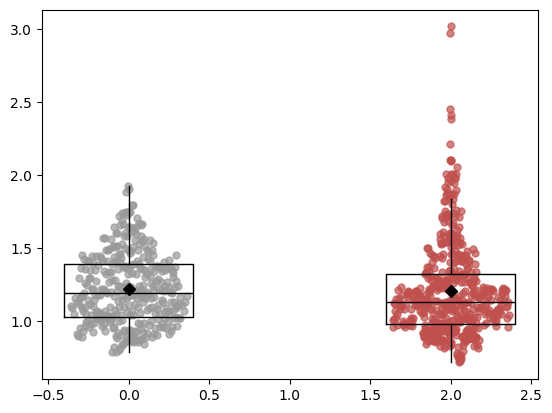

In [264]:
boxplot_kw = plt_multi_boxplot.boxplot_kw
scatter_kw = plt_multi_boxplot.scatter_kw
width = boxplot_kw.get("widths", 0.5) * 0.9

ax = plt.gca()
for g, data in gdatas.items():
    # display(data)
    data = data['mean_c1'].values
    # xs = g + np.random.uniform(-width/2, -width/2, len(data))
    xs = g + ptshist(data, width, bins=20)
    ax.plot(xs, data, ls="none", color=ENV['group_colors'][g], marker="o", markersize=5, **scatter_kw)  # marker=markers[i], **scatter_kw)
    ax.boxplot(data, positions=[g], manage_ticks=False, **boxplot_kw)


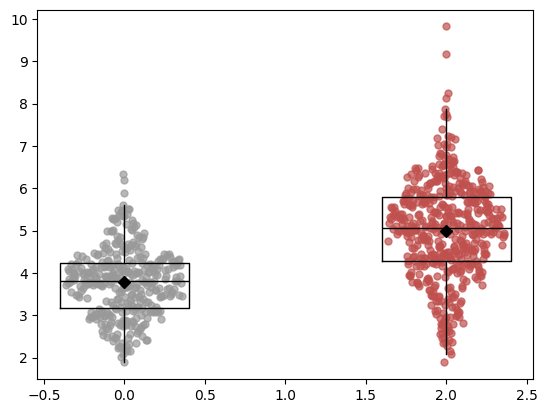

In [266]:
ax = plt.gca()
for g, data in gdatas.items():
    # display(data)
    data = data['mean_c3'].values
    # xs = g + np.random.uniform(-width/2, -width/2, len(data))
    xs = g + ptshist(data, width, bins=20)
    ax.plot(xs, data, ls="none", color=ENV['group_colors'][g], marker="o", markersize=5, **scatter_kw)  # marker=markers[i], **scatter_kw)
    ax.boxplot(data, positions=[g], manage_ticks=False, **boxplot_kw)

In [42]:
ckpts['ivf_histology_v0']

ckpt_ivf_histology_v0(src=PosixPath('../ivf_hist/nuclei_measure/2MA'), dst=PosixPath('../checkpoints/table_ckpt_v1/ivf_histology_v0.csv'))

In [82]:
def __():
    # from lib.statplots import np_reduce_mean_sd_count
    rows = []
    hist_table_dir = Path('../ivf_hist/nuclei_measure/2MA')
    i = 0
    for p in hist_table_dir.iterdir():
        name = p.name
        if not name.endswith(".bg.csv"):
            continue
        if "_cortex_" not in name:
            continue
        i += 1
        if i % 2:
            continue
            
        p1 = hist_table_dir / name.replace(".bg.csv", ".csv")
        parts = name.removesuffix(".bg.csv").split("_")
        
        row = dict(zip(["animal", "p1", "p2"], parts[:-3]))
        row['snap_id'] = parts[-1]    # there can be 4 or 5 parts in the name
        row['region'] = parts[-2]
        row['side'] = parts[-3]
        if parts[0] in ["10r", "10null", "19.1l", "19.1r"]:
            row['group'] = 0
        else:
            row['group'] = 2
        
        bgt = pd.read_csv(p, index_col=0)
        ht = pd.read_csv(p1, index_col=0)
        def __get_channel(x): return ord(x[1]) - 48 # ascii arithmetic 
        bgt["Channel"] = bgt["Label"].map(__get_channel)
        bgt.set_index("Channel", inplace=True)
        ht["Channel"] =  ht["Label"].map(__get_channel)
        ht["Roi"] = ht["Label"].map(lambda x: x[11:])
        ht.set_index(["Channel", "Roi"], inplace=True)
        # while mean brightness is can be heavily influenced by histological artifacts, boundaries and light distribution,
        # median is influenced primarily by the amount of dye and illumination strength / filters etc.
        ht["MeanN"] =  ht["Mean"] / bgt["Median"]
        ht["StdDevN"] = ht["StdDev"] / bgt["Median"]
        
        
        #= ==============================
        # display(ht)
        colors = ["#17af07", "#d86704", "#042ed8"]
        gdata = [ht.loc[ch, 'MeanN'].values for ch in range(1, 4)]
        
        
        fig, axs = plt.subplots(1, 3, figsize=(8, 4), layout="compressed")
        axs = axs.ravel()
        for i in range(3):
            data = gdata[i]
            ax = axs[i]
            # kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(data.reshape(-1, 1))
            # xs_pred = np.linspace(data.min(), data.max()).reshape((-1, 1))
            # ys_pred = np.exp(kde.score_samples(xs_pred))
            bins=50
            gdata_hist = np_pts_to_scatter_histogram(data.ravel(), bins=bins, align_to='side')[0]
            # ax.plot(xs_pred, ys_pred, color=colors[i], lw=3, alpha=0.7)
            ax.plot(data, gdata_hist, color=colors[i], ls="none", marker="o", alpha=0.5, markersize=3)
            histy, histx = np.histogram(data, bins=bins,)
            histy = histy/ histy.max()
            ax.plot(histx[:-1], histy, ds='steps-post', color=colors[i])
            # ax.hist(data, bins=bins, histtype='step', density=True, alpha=0.7, lw=2)
        plt_figsave_png_96dpi(ENV['outd']/f"hists/{name}", fig)
    print("done")
__()

../workbooks/today/hists/01r_2_right_cortex_26375.bg.csv
../workbooks/today/hists/10r_2_3_left_cortex_26818.bg.csv
../workbooks/today/hists/10r_2_1_right_cortex_26785.bg.csv
../workbooks/today/hists/01l_3_right_cortex_26642.bg.csv
../workbooks/today/hists/07null_1_right_cortex_26665.bg.csv
../workbooks/today/hists/23null_2_right_cortex_26469.bg.csv
../workbooks/today/hists/07l_3_left_cortex_26972.bg.csv
../workbooks/today/hists/23lr_2_right_cortex_26909.bg.csv
../workbooks/today/hists/19.1r_1_3_right_cortex_26224.bg.csv
../workbooks/today/hists/01l_2_right_cortex_26610.bg.csv
../workbooks/today/hists/02null_3_left_cortex_27037.bg.csv
../workbooks/today/hists/10r_1_3_right_cortex_26051.bg.csv
../workbooks/today/hists/19.1l_1_2_left_cortex_26194.bg.csv
../workbooks/today/hists/10null_1_right_cortex_26079.bg.csv
../workbooks/today/hists/19.1l_1_3_right_cortex_26229.bg.csv
../workbooks/today/hists/19.1r_1_1_right_cortex_26165.bg.csv
../workbooks/today/hists/01r_3_left_cortex_26402.bg.csv
.

In [ ]:
plt_kde

In [46]:
from sklearn.neighbors import KernelDensity

In [79]:
def plt_figsave_png_96dpi(path, fig):
    fig.savefig(path.with_suffix(".png"), dpi=96)
    plt.close(fig)
    print(path)

In [72]:
import inspect
print(inspect.getsource(plt_figsave_png_300dpi))

def plt_figsave_png_300dpi(path, fig):
    fig.savefig(path.with_suffix(".png"), bbox_inches="tight", dpi=300)
    plt.close(fig)
    print(path)



In [73]:
ENV['figsave']

<function __main__.plt_figsave_png_300dpi(path, fig)>

In [74]:
ENV['outd']

PosixPath('../workbooks/today')

## pressure monitor

Mice 1 25000 начало 14:14 конец 14:16:30 –запах; потом две минуты воздуха 

Mice 2 35900 начало 14:28:20 конец 14:31; две минуты воздуха 

Mice 3 9500 начало  14:45 конец 14:48; две минуты воздуха 


/home/data/.local/lib/python3.12/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


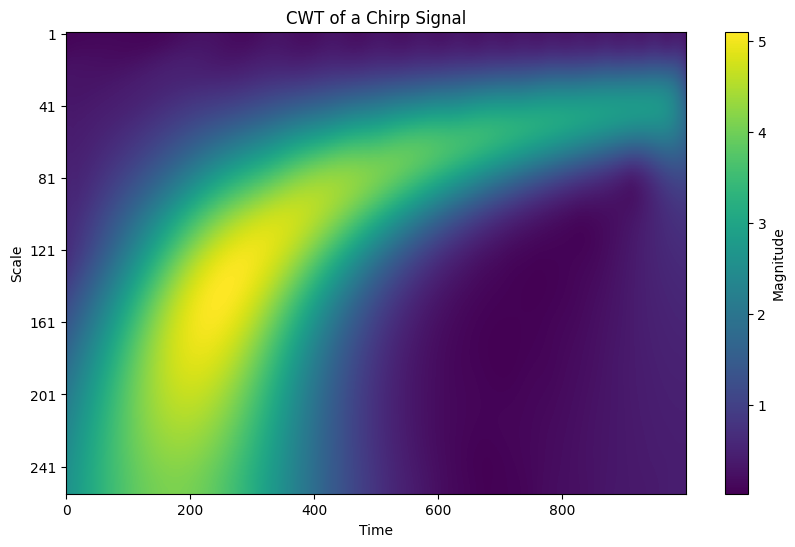

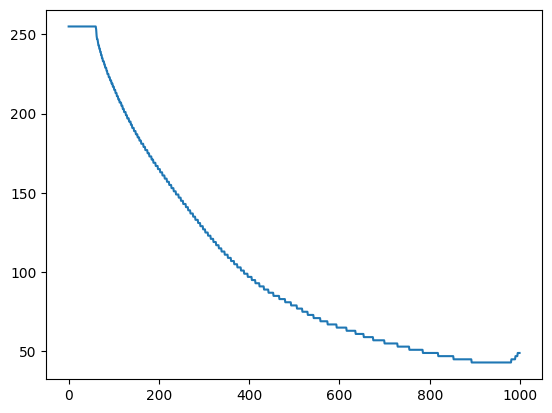

In [4]:
import pywt
from scipy import ndimage
# https://www.scicoding.com/introduction-to-wavelet-transform-using-python/

# Generate a chirp signal
t = np.linspace(0, 1, 1000, endpoint=False)
signal = np.sin(2.0 * np.pi * 7 * t * t)

# Apply CWT
scales = np.arange(1, 256, 2)
coef, freq = pywt.cwt(signal, scales=scales, wavelet='cmor')
magn = np.abs(coef)
magn = ndimage.gaussian_filter(magn, sigma=(5, 1))
# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(magn, aspect='auto', cmap='viridis',)
plt.yticks(np.arange(len(scales))[::20], scales[::20])
plt.colorbar(label="Magnitude")
plt.ylabel("Scale")
plt.xlabel("Time")
plt.title("CWT of a Chirp Signal")
plt.show()
plt.figure()
timescales = scales[np.argmax(magn, axis=0)]
plt.plot(timescales)

In [30]:
def CompTime_to_ms(x):
        h, m, s= map(int, x.split(':'))
        return ((h-10)*3600 + m*60 + s)*100


def __():

    def linearize_comptime(xs):
        x0 = xs[0]
        startpos = np.where(x0 != xs[:120])[0][0] # find first jump
        realx0 = xs[startpos] - startpos
        return np_arange(realx0, 1, len(xs)).astype(int)
    
    d = Path("../pressure monitor/")
    fnames = [
        "Exp2024_04_25_14_18mice1.dat",
        "Exp2024_04_25_14_33mice2.dat",
        "Exp2024_04_25_14_50mice3.dat",
    ]
    f = CompTime_to_ms
    bounds = [
        (f("14:14:00"), f("14:16:30"), f("14:18:30"),),
        (f("14:28:20"), f("14:31:00"), f("14:32:00"),),
        (f("14:45:00"), f("14:48:00"), f("14:50:00"),), 
    ]
    
    dfs = []
    for fname, bound in zip(fnames, bounds):
        path = d/fname
        df = pd.read_csv(path, sep="\t", index_col=["NN"])
        # time is in h:m:s format, but the pressure is measured each millisecond
        df['msCompTime'] = df.CompTime.map(CompTime_to_ms)
        msT = linearize_comptime(df.msCompTime.values) # absolute time, in milliseconds
        df['msT'] = msT
        bound_idx = [np.where(msT < b)[0][-1] for b in bound]
        dfs.append(NSdict(fname=fname, df=df, bounds=bound, bound_idxs=bound_idx))
    return dfs
dfs = __()

In [8]:
df = dfs[0].df
signal = df.Pressure
scales = np.arange(1, 256)
coefficients, frequencies = pywt.cwt(signal, scales=scales, wavelet='cmor')
magnitude = np.abs(coefficients)

/home/data/.local/lib/python3.12/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


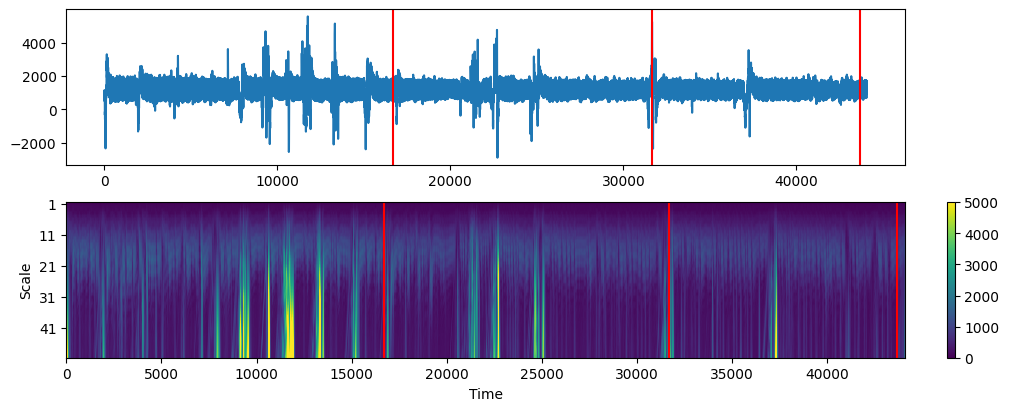

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), layout="compressed")
plt.sca(axs[0])
plt.plot(signal)
for b in dfs[0].bound_idxs:
    plt.axvline(b, c="r")
plt.sca(axs[1])
plt.imshow(magnitude[:50], aspect='auto', cmap='viridis')
plt.yticks(np.arange(len(scales))[:50:10], scales[:50:10])
plt.colorbar()
plt.clim(0, 5000)
plt.ylabel("Scale"); plt.xlabel("Time")
for b in dfs[0].bound_idxs:
    plt.axvline(b, c="r")


Text(0.5, 0, 'Time')

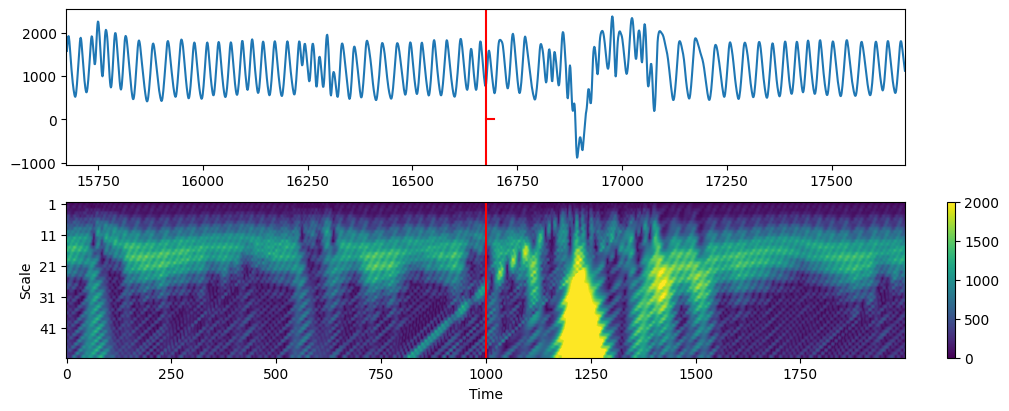

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), layout="compressed")
plt.sca(axs[0])
o = 16675
d = 1000
plt.plot(signal[o-d:o+d])
plt.xlim(o-d, o+d)
plt.plot([o, o+20], [0,0], c="r")
plt.axvline(o, c="r")
plt.sca(axs[1])
su = 50
plt.imshow(magnitude[:su, o-d:o+d], aspect='auto', cmap='viridis')
plt.yticks(np.arange(len(scales))[:su:su//5], scales[:su:su//5])
plt.axvline(d, c="r")
plt.colorbar()
plt.clim(0, 2000)
plt.ylabel("Scale"); plt.xlabel("Time")

In [23]:
dfs[0].bound_idxs

[16675, 31675, 43675]

In [24]:
16675-31675, 31675-43675

(-15000, -12000)

/home/data/.local/lib/python3.12/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/home/data/.local/lib/python3.12/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/home/data/.local/lib/python3.12/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwid

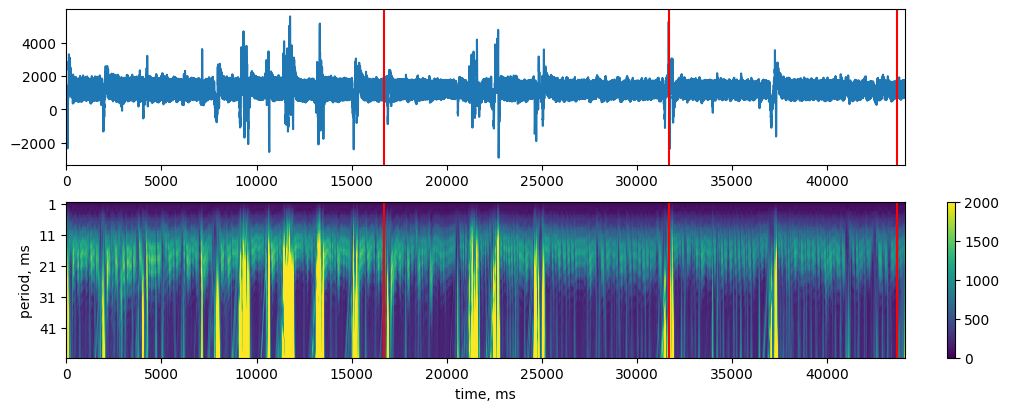

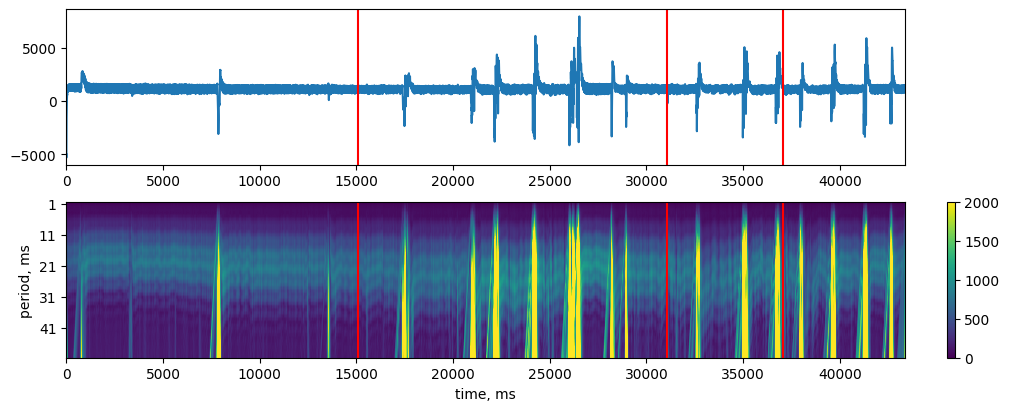

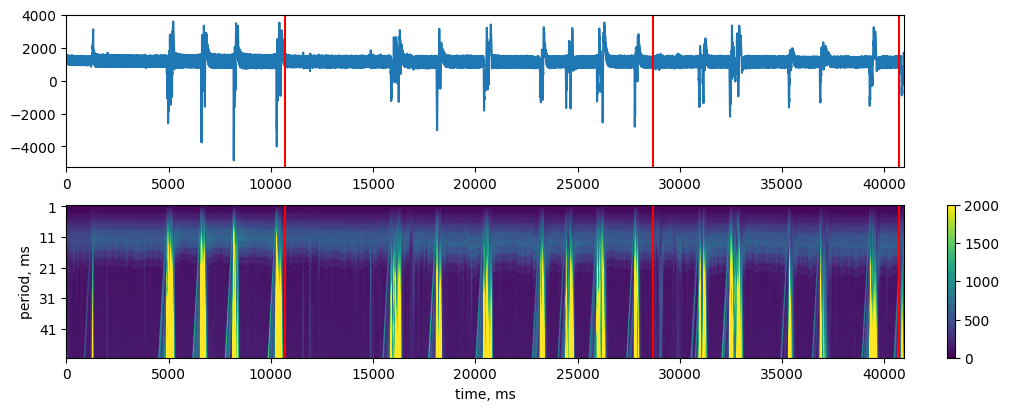

In [32]:
for i in range(3):
    df = dfs[i].df
    signal = df.Pressure
    scales = np.arange(1, 51)
    coefficients, frequencies = pywt.cwt(signal, scales=scales, wavelet='cmor')
    magnitude = np.abs(coefficients)
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 4), layout="compressed")
    plt.sca(axs[0])
    plt.plot(signal)
    plt.xlim(0, len(signal))
    f = lambda v: plt.axvline(v, c="r")
    for b in dfs[i].bound_idxs: f(b)
    plt.sca(axs[1])
    su = 50
    plt.imshow(magnitude[:su], aspect='auto', cmap='viridis')
    plt.yticks(np.arange(len(scales))[:su:su//5], scales[:su:su//5])
    for b in dfs[i].bound_idxs: f(b)
    plt.colorbar()
    plt.clim(0, 2000)
    plt.ylabel("period, ms"); plt.xlabel("time, ms")

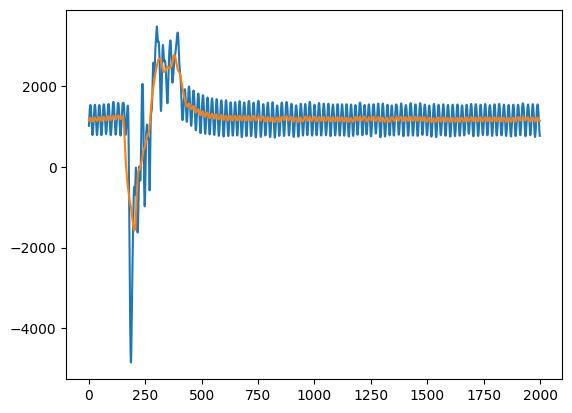

In [51]:
n=50
pc= ndimage.convolve1d(df.Pressure, np.full(n, 1/n), mode='reflect')

s = slice(8000, 10000)
plt.plot(df.Pressure.values[s])
plt.plot(pc[s])

## Aryana thesis no 3 workbook

In [30]:
%run -i framework.py
# non-standard workbook in a single function
plot_Aryana_thesis_no3(tbls['nonparametric_ts_sum_v0'], tbls['activity_ts_v0'], tbls['ivf_features_v0'])

../workbooks/misc/Aryana_thesis_no3.svg
../workbooks/misc/Aryana_thesis_no3_alt1.svg


## reactive prototype

In [91]:
def fn_abc(a, b):
    return 3

def fn_abd(a, b):
    return 4

def fn_cde(c, d):
    return 5

def fn_aeda2(a, e, d):
    return 1+1j

fn = {
    "c": (fn_abc, "a", "b", ),
    "d": (fn_abd, "a", "b", ),
    "e": (fn_cde, "c", "d", ),
    "a2": (fn_aeda2, "a", "e", "d",),
}

inp = {"a": 1, "b": 2}
for act in ["c", "d", "e", "a2"]:
    fni = fn[act]
    inp[act] = fni[0](*(inp[k] for k in fni[1:]))
inp

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'a2': (1+1j)}

In [92]:
def make_roadmap(dst, src, graph=None):
    if graph is None:
        graph = src
        src = set()
    else:
        src = set(src)
    dst = list(dst)
    roadmap = dst.copy()
    for x in dst:
        if x not in src:
            src.add(x)
        roadmap.append(x)
        edge = graph[x]
        dst.extend(edge[1:])
    roadmap.reverse()
    return roadmap

make_roadmap(dst = ["a2"], src={"a": 1, "b": 2}, graph=fn)

KeyError: 'a'

# ivf histology

In [4]:
tbls['ivf_histology_v0']


snap_id  animal  group  p1  p2  region   side  area_mean   area_sum  \
0      26611     01l      2   1 NaN  cortex   left  68.154721  20241.952   
1      26612     01l      2   1 NaN  cortex   left  71.384814  22985.910   
2      26613     01l      2   1 NaN  cortex   left  72.296140  16555.816   
3      26614     01l      2   1 NaN  cortex   left  71.264404  16248.284   
4      26615     01l      2   1 NaN  cortex   left  66.884975  23677.281   
..       ...     ...    ...  ..  ..     ...    ...        ...        ...   
854    26499  23null      2   3 NaN  cortex  right  45.067644   6579.876   
855    26500  23null      2   3 NaN  cortex  right  49.214612   6348.685   
856    26501  23null      2   3 NaN  cortex  right  41.665019   2166.581   
857    26502  23null      2   3 NaN  cortex  right  48.205546   7327.243   
858    26503  23null      2   3 NaN  cortex  right  40.774750   3098.881   

       area_sd  cell_count   mean_c1   mean_c2   mean_c3     sd_c1     sd_c2  \
0    24.263983         297  0.963987  1.944684  4.402348  0.214122  1.234567   
1    26.031581         322  0.918691  1.737731  4.217770  0.210889  1.085467   
2    35.528955         229  1.011518  2.040654  4.748914  0.262047  1.371409   
3    25.064247         228  1.017923  1.984777  4.290886  0.227465  1.269559   
4    22.132147         354  0.919476  1.665159  3.957612  0.183449  0.944573   
..         ...         ...       ...       ...       ...       ...       ...   
854  12.829357         146  1.025001  2.822377  2.426346  0.270993  2.152406   
855  17.496020         129  1.107350  3.198626  2.156124  0.401819  3.057848   
856  11.017007          52  1.133001  4.235793  2.576706  0.344549  3.754058   
857  14.663794         152  0.960484  2.940690  2.082017  0.229916  2.239071   
858   8.724173          76  1.039702  3.635121  2.372748  0.320962  2.833346   

        sd_c3  
0    2.801771  
1    2.560161  
2    2.953807  
3    2.449495  
4    2.176244  
..        ...  
854  0.887108  
855  0.823793  
856  0.925355  
857  0.715385  
858  0.862304  

[859 rows x 17 columns]

In [16]:
ENV.update( {
        'group_colors': ['#a040f0', '#f0a040', ],
        'group_labels': ['WT', 'IVF'],
        'groups': [0, 2],
        'lang': LANG_EN,
        'letters': plt_add_letters(LETTERS_EN),
})

In [31]:
gts = hist_agg_side.groupby(["group", "side"])
xl = gts.get_group((0, 'left')).set_index("animal").drop(columns=["side", "group", "slice_count"])
display(xl)
xr = gts.get_group((0, 'right')).set_index("animal").drop(columns=["side", "group", "slice_count"])
display(xr)
display(xl/xr)
gts

cell_count  area_mean    area_sd     area_sum   mean_c1     sd_c1   
animal                                                                      
10null        8077  69.136915  25.368895   558418.865  1.541520  0.520704  \
10r          18349  60.955232  21.582409  1118467.546  1.202601  0.445120   
19.1l         8754  60.173998  20.548549   526763.182  0.940529  0.241326   
19.1r        14082  55.473286  19.924297   781174.818  1.250285  0.367836   

         mean_c2     sd_c2   mean_c3     sd_c3  
animal                                          
10null  3.353970  2.612754  3.915466  2.194329  
10r     2.754160  2.547347  4.460078  2.698858  
19.1l   1.457445  1.050711  3.101392  1.545325  
19.1r   2.919452  1.709902  4.298196  2.250623

cell_count  area_mean    area_sd     area_sum   mean_c1     sd_c1   
animal                                                                      
10null        8365  67.168400  24.124948   561863.663  1.433670  0.526496  \
10r          17726  59.140075  20.856834  1048316.978  1.265330  0.474358   
19.1l         7822  57.020358  20.243038   446013.242  1.028077  0.279416   
19.1r        12960  57.628571  22.689036   746866.276  1.180955  0.386856   

         mean_c2     sd_c2   mean_c3     sd_c3  
animal                                          
10null  2.939943  2.118145  3.994231  2.228417  
10r     3.167992  2.901365  3.851110  2.123453  
19.1l   1.954580  1.298319  3.132411  1.499010  
19.1r   2.736090  2.200874  3.459424  2.079078

cell_count  area_mean   area_sd  area_sum   mean_c1     sd_c1   
animal                                                                  
10null    0.965571   1.029307  1.051563  0.993869  1.075226  0.988999  \
10r       1.035146   1.030692  1.034788  1.066917  0.950425  0.938362   
19.1l     1.119151   1.055307  1.015092  1.181048  0.914844  0.863680   
19.1r     1.086574   0.962600  0.878146  1.045937  1.058707  0.950835   

         mean_c2     sd_c2   mean_c3     sd_c3  
animal                                          
10null  1.140828  1.233511  0.980280  0.984703  
10r     0.869371  0.877982  1.158128  1.270976  
19.1l   0.745656  0.809286  0.990097  1.030897  
19.1r   1.067016  0.776919  1.242460  1.082510

In [36]:
ch_titles = {1: 'di-methyl', 2: 'acetyl', 3: 'DAPI'}

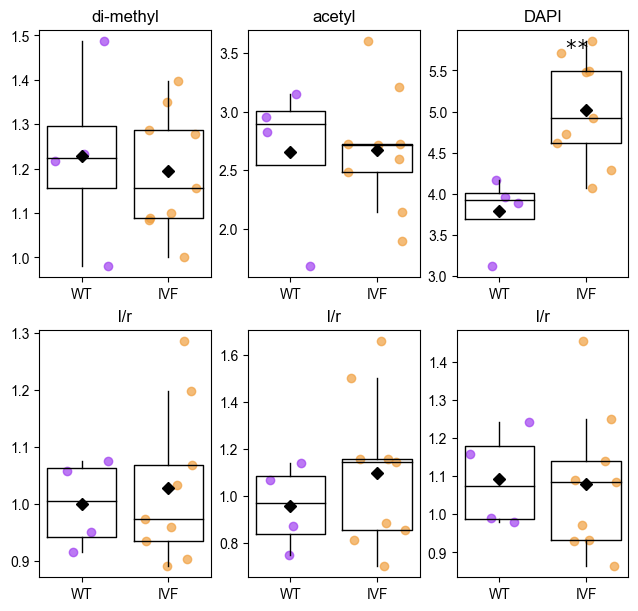

In [39]:
gt = hist_agg.groupby("group")
gts = hist_agg_side.groupby(["group", "side"])

get_gts = lambda g, side, col: gts.get_group((g, side))[col].values

fig, axs = plt.subplots(2, 3, figsize=(c_A4_w-2, 6), layout="compressed")
axs = axs.ravel()
for ch in range(1, 4):
    ax = axs[ch-1]
    gdata = [gt.get_group(g)[f"mean_c{ch}"].values for g in gt.groups]
    # print(gdata) 
    boxplot_main(ax, gdata, ENV)
    ax.set_title(ch_titles[ch])
    
    ax = axs[ch+2]
    gdata = [get_gts(g, 'left', f"mean_c{ch}")/get_gts(g, 'right', f"mean_c{ch}") for g in gt.groups]
    boxplot_main(ax, gdata, ENV)
    # plt_kde_groups(ax, gdata, colors = "red orange blue cyan".split(), labels=[str(g) for g in gt.groups])
    ax.set_title("l/r")
# axs[0].legend()

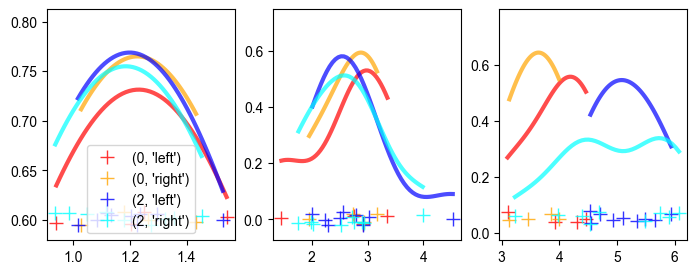

In [14]:
gt = hist_agg_side.groupby(["group", "side"])

fig, axs = plt.subplots(1, 3, figsize=(c_A4_w, 3))
axs = axs.ravel()
for ch in range(1, 4):
    ax = axs[ch-1]
    gdata = [gt.get_group(g)[f"mean_c{ch}"].values for g in gt.groups]
    # print(gdata) 
    plt_kde_groups(ax, gdata, colors = "red orange blue cyan".split(), labels=[str(g) for g in gt.groups])
axs[0].legend()


        t(wtL, wtR)=0.0000
        t(ivfL, ivfR)=0.0036
        t(wtL, ivfL)=0.0000
        t(wtR, ivfR)=0.0000
        


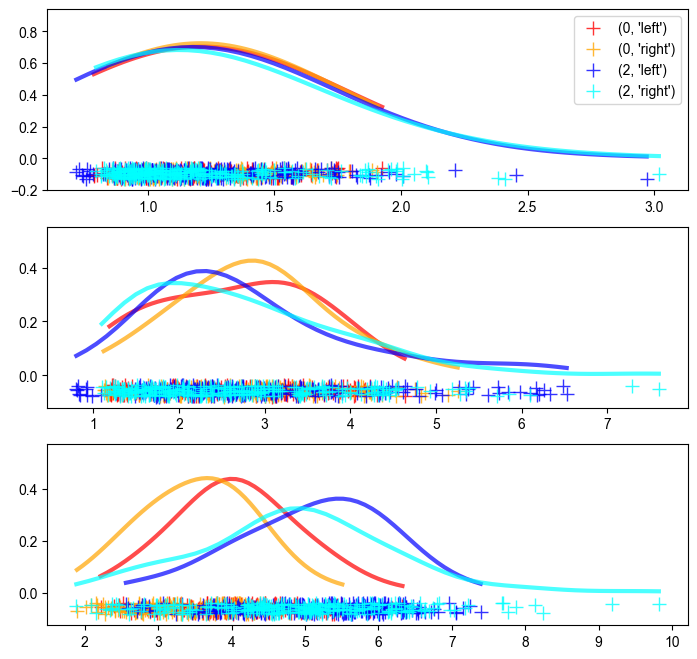

In [117]:
gt = hist_t.groupby(["group", "side"])

fig, axs = plt.subplots(3, 1, figsize=(c_A4_w, 8))
axs = axs.ravel()
for ch in range(1, 4):
    ax = axs[ch-1]
    gdata = [gt.get_group(g)[f"mean_c{ch}"].values for g in gt.groups]
    if ch == 3:
        t = test_mwu
        wtL = gdata[0]
        wtR = gdata[1]
        ivfL = gdata[2]
        ivfR = gdata[3]
        print(f"""
        {t(wtL, wtR)=:.4f}
        {t(ivfL, ivfR)=:.4f}
        {t(wtL, ivfL)=:.4f}
        {t(wtR, ivfR)=:.4f}
        """)
    # print(gdata) 
    plt_kde_groups(ax, gdata, colors = "red orange blue cyan".split(), labels=[str(g) for g in gt.groups])
axs[0].legend()

In [113]:
t = test_t_ind
wtL = gdata[0]
wtR = gdata[1]
ivfL = gdata[2]
ivfR = gdata[3]
print(f"""
{t(wtL, wtR)=}
{t(ivfL, ivfR)=}
{t(wtL, ivfL)=}
{t(wtR, ivfR)=}
""")


t(wtL, wtR)=0.39506280429044616
t(ivfL, ivfR)=0.5058752561462073
t(wtL, ivfL)=0.01855581422755625
t(wtR, ivfR)=0.005985206658990756



In [ ]:
def plot_histology_channel_kde_v0():
    from sklearn.neighbors import KernelDensity
    xlims = [(0.9, 1.55), (1.5, 4), (3, 6)]
    floors = [0.650, 0.20, 0.25]
    fig, axs = plt.subplots(1, 3, figsize=(c_A4_w, 3))
    axs = axs.ravel()
    tg = hist_agg.groupby("group")
    for ch in range(1, 4):
        ax = axs[ch-1]
        gdata = []
        plot_data = []
        for g in [0, 2]:
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            gdata.append(xs)
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(xs[:, None])
            xs_pred = np.linspace(xs.min(), xs.max())[:, None]
            ys_pred = np.exp(kde.score_samples(xs_pred))
            color = "#9030e0" if gt.iloc[0]["group"]==0 else "#e09030"
            plot_data.append((xs, xs_pred, ys_pred, color))
        _ = np.concatenate((plot_data[0][2], plot_data[1][2]))
        mi, ma = _.min(), _.max() 
        for (xs, xs_pred, ys_pred, color) in plot_data:
            ax.plot(xs, mi * np.ones_like(xs) + 0.1*(mi-ma), ls="none", marker="+", markersize=10, color=color, alpha=0.8)
            ax.plot(xs_pred, ys_pred, color=color, lw=3, alpha=0.7)
            ax.set_title(f"{CHANNEL_NAMES_EN[ch]}")
            ax.set_ylim(mi + 0.3*(mi-ma), 0.8)
            ax.set_xlim(*xlims[ch-1])
        ps = cmp_to_words_2_gr(gdata, ENV['test2'], do_trend=False)[0]
        ax.annotate(ps, (0.7, 0.8), xycoords='axes fraction')
        
    axs[0].plot([], [], color="#a040f0", lw=3, label="WT")
    axs[0].plot([], [], color="#f0a040", lw=3, label="IVF")
    axs[0].legend()
    fig.align_ylabels()
    plt.savefig(ENV['outd'] / "hist_aggregated_kde_v0.svg", bbox_inches="tight")
plot_histology_channel_kde_v0()

## table for YMoshkin

In [73]:
class ckpt_ivf_histology_source_v0(NT):
    src: Path
    dst: Path
    # animals: dict[int, list[int]]
    
    def ckpt_create(self): 
        px_per_mkm = 5.5507
        blocks = []
        hist_table_dir = self.src
        for p in hist_table_dir.iterdir():
            name = p.name
            if not name.endswith(".bg.csv"):
                continue
            if "_cortex_" not in name:
                continue
            p1 = hist_table_dir / name.replace(".bg.csv", ".csv")
            parts = name.removesuffix(".bg.csv").split("_")
            
            row = dict(zip(["animal", "p1", "p2"], parts[:-3]))
            row['snap_id'] = parts[-1]    # there can be 4 or 5 parts in the name
            row['region'] = parts[-2]
            row['side'] = parts[-3]
            if parts[0] in ["10r", "10null", "19.1l", "19.1r"]:
                row['group'] = 0
            else:
                row['group'] = 2
            
            bgt = pd.read_csv(p, index_col=0)
            ht = pd.read_csv(p1, index_col=0)
            def __get_channel(x): return ord(x[1]) - 48 # ascii arithmetic 
            bgt["channel"] = bgt["Label"].map(__get_channel)
            bgt["nucleus_id"] = "whole_image"
            
            # bgt.set_index(["Channel", "Roi"], inplace=True)
            ht["channel"] =  ht["Label"].map(__get_channel)
            ht["nucleus_id"] = ht["Label"].map(lambda x: x[11:])
            # ht.set_index(["Channel", "Roi"], inplace=True)
            # while mean brightness is can be heavily influenced by histological artifacts, boundaries and light distribution,
            # median is influenced primarily by the amount of dye and illumination strength / filters etc.
            jt = pd.concat([ht, bgt], ignore_index=True)
            del bgt, ht
            
            jt["snap_id"] = row["snap_id"]
            jt["animal"] = row["animal"]
            jt["group"] = row["group"]
            jt["p1"] = row.get("p1")
            jt["p2"] = row.get("p2")
            jt["region"] = row["region"]
            jt["side"] = row["side"]

            jt.set_index(["snap_id", "animal", "group", "p1", "p2", "region", "side", "channel", "nucleus_id"], inplace=True)
            jt = jt[["Area", "Mean", "StdDev", "Median", "Mode", "Min", "Max"]]
            blocks.append(jt)
        t = pd.concat(blocks)
        t.sort_index(inplace=True)
        t = t.reset_index()
        t.drop(columns=["p1", "p2"], inplace=True)
        t.to_csv(self.dst, sep="\t")
        return t
    ckpt_load = ckpt_load_default
ckpt_ivf_histology_source_v0.name = ckpt_name(ckpt_ivf_histology_source_v0)


c = ckpt_ivf_histology_source_v0(
    src=Path("ivf_hist/nuclei_measure/2MA/"), 
    dst=Path(f"checkpoints_test/{ckpt_ivf_histology_source_v0.name}.csv"),
)
t = c.ckpt_create()

# (channel, roi)

In [80]:
anims = list(t["animal"].unique())

In [89]:
len(anims)
gs = [[], []]
for a in anims:
    if a in ["10r", "10null", "19.1l", "19.1r"]:
        gs[0].append(a)
    else:
        gs[1].append(a)
len(gs[1])

9

[0.00543476 0.01869796 0.01029831 0.00374149 0.00961674 0.00300963
 0.00454269 0.00460159 0.00897001 0.00323049 0.00791994 0.00034079
 0.00875859 0.00484576 0.01259483 0.02093272 0.01834496 0.00546926
 0.00654936 0.0068772 ]


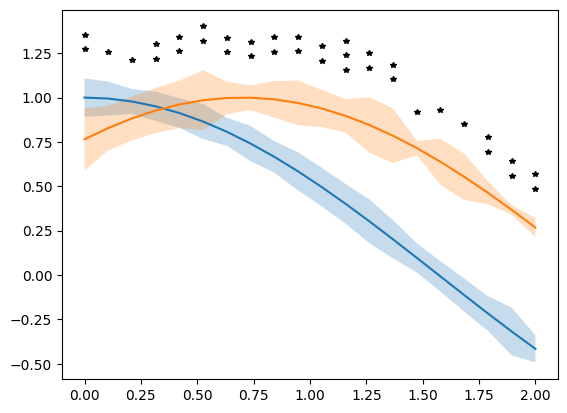

In [44]:
def plt_2sample_dynamics(ax, x, y1, erry1, y2, erry2, pvalues=None):
    plot_style = dict()
    fill_style = dict(alpha=0.25)
    ax.plot(x, y1, **plot_style)
    l1, h1 = y1-erry1, y1+erry1
    ax.fill_between(x, l1, h1, **fill_style)
    ax.plot(x, y2, **plot_style)
    l2, h2 = y2-erry2, y2+erry2
    ax.fill_between(x, l2, h2, **fill_style)
    
    if pvalues is None:
        return
    bounds = np.stack([l1, h1, l2, h2], axis=0) # стэкуем границы закрашенных областей
    mi, ma = bounds.min(axis=0), bounds.max(axis=0) 
    span = (ma.max()-mi.min()) # расстояние между минимумом и максимумом всего
    step = 0.05*span # из этого рассотояния делаем отступ вверх
    for i, thresh in enumerate([0.05, 0.01, 0.001]):
        mask =  pvalues < thresh
        y = ma + (i+2)*step
        ax.plot(x[mask], y[mask], ls='none', marker="*", markersize=4, c="k") 
    

x = np.linspace(0, 2, 20)
y1 = np.cos(x)
y2 = np.cos(x-0.7)
erry1 = 0.1 + 0.02 *np.random.randn(*x.shape)
erry2 = 0.1 + 0.04 *np.random.randn(*x.shape)
pvalues = np.abs(0.01 * np.random.randn(*x.shape))
print(pvalues)
plt_2sample_dynamics(plt.gca(), x, y1, erry1, y2, erry2, pvalues)

# Gerlinskaya tables

## prelude

In [4]:
%run -i ./framework.py
%run -i ./framework_embryo.py
# include_path("./framework_embryo.py")

ENV['group_colors'] = ["#999999", "#4f81bd", "#c0504d", "#9bbb59"]
ENV['group_labels'] = ["in-vivo", "35°C", "37°C", "39°C"]
ENV['letters'] = plt_add_letters(LETTERS_EN)
ENV['extra_letters'] = True
ENV['do_axlabels'] = True#False
ENV['extra_letters_kw'] = dict(fontsize=12, horizontalalignment='center', backgroundcolor="#ffffff50")


In [55]:

def cmpplot(ax, ann, x0, x1, y):
    ax.plot([x0, x1], [y, y], c="k", lw=1.5)
    ax.annotate(ann, ((x0+x1)/2, y), horizontalalignment="center", weight="bold", fontsize=15)

def cmpplot2(ax, ann, x0, x1, y):
    ax.plot([x0-0.2, x1+0.2], [y, y], c="k", lw=1.5)
    ax.annotate(ann, ((x0+x1)/2, y), horizontalalignment="center", weight="bold", fontsize=15)

def ptshist(data, width, bins=None):
    if bins is None:
        bins=10
    if type(bins) is int:
        bins = np.linspace(data.min()*0.95, data.max()*1.05, 10)
    return (np_pts_to_scatter_histogram(data.ravel(), bins=bins)[0] - 0.5)*width


def pval_to_int(p):
    if p > 0.05: return 0
    elif p > 0.01: return 1
    elif p > 0.001: return 2
    else: return 3

def stat_2d_pval_table_to_sparse(lsd):
    lsd = lsd.copy()
    lotri = np.tri(*lsd.shape, dtype=bool)
    lsd.values[lotri] = np.nan
    lsd = lsd.unstack(0).unstack().dropna()
    lsd = lsd[lsd < 0.05]
    return lsd

In [48]:
import subprocess
from io import StringIO

def to_clipboard_linux(string):
    if type(string) == StringIO:
        string.seek(0)
        string = string.read()
    if type(string) == str:
        string = string.encode('utf-8')
    subprocess.run(['xsel', '-bi'], input=string)

def _df_to_clip(df, *args, **kwargs):
    f = StringIO()
    df.to_csv(f, *args, **kwargs)
    to_clipboard_linux(f)
    input("press enter to proceed")

## embryo wb v0

In [7]:
hook = dict()

In [11]:
embryo_cell_mass_v0 = ckpt_fn_embryo_cell_mass_v0("../data_src")
ivf_embryo_methylation_v0 = ckpt_fn_ivf_embryo_methylation_v0()
# plot_FIG9_cell_mass_distribution_v0(embryo_cell_mass_v0, ENV)
# plot_FIG9_cell_mass_distribution_v1(embryo_cell_mass_v0, ENV)
# plot_FIG9_cell_mass_distribution_v1b(embryo_cell_mass_v0, ENV)

phony save #=PHONY=#/FIG9_cell_mass_distribution_v2.svg


press enter to proceed 


press enter to proceed 
press enter to proceed 


press enter to proceed 
press enter to proceed 


press enter to proceed 
press enter to proceed 


press enter to proceed 
press enter to proceed 


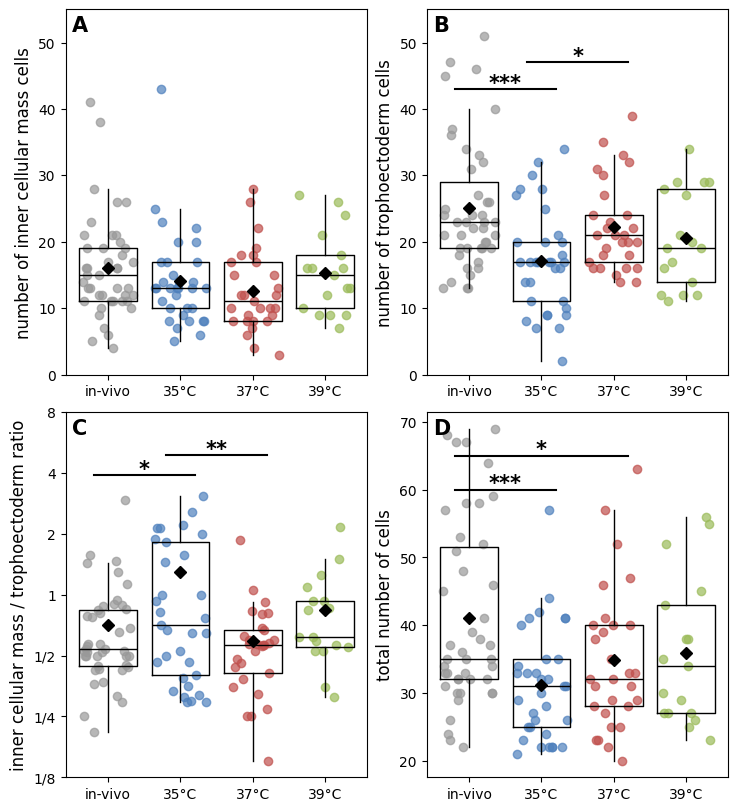

In [12]:
plot_FIG9_cell_mass_distribution_v2(embryo_cell_mass_v0)

for_anova = hook['fig9_for_anova']
for_anova['log2_ICM_TE_ratio'] = np.log2(for_anova['ICM_TE_ratio'])
_df_to_clip(for_anova, sep="\t", float_format="%.4f", index=False)
print()
for dat_col in ['ICM', 'TE', 'log2_ICM_TE_ratio', 'Total_cells']:
    # print("what\t anova\t anova_stars")
    anova = stats_anova1w(for_anova, 'Group', dat_col)
    anova_p = anova.loc['C(Group)', 'PR(>F)']
    _df_to_clip(anova, sep="\t", float_format="%.4f")
    lsd = stats_fisher_lsd_1d(anova, for_anova, 'Group', dat_col)
    _df_to_clip(lsd.astype(float), sep="\t", float_format="%.4f")
    print()
    # print(stat_1d_pval_table_to_sparse(lsd).map(lambda x: pval_to_int(x)*'*'))
    # print('=='*10)

phony save #=PHONY=#/FIG10_5mC_PI_ratio_v1.svg
phony save #=PHONY=#/FIG10b_5mC_PI_ratio_CV_v1.svg


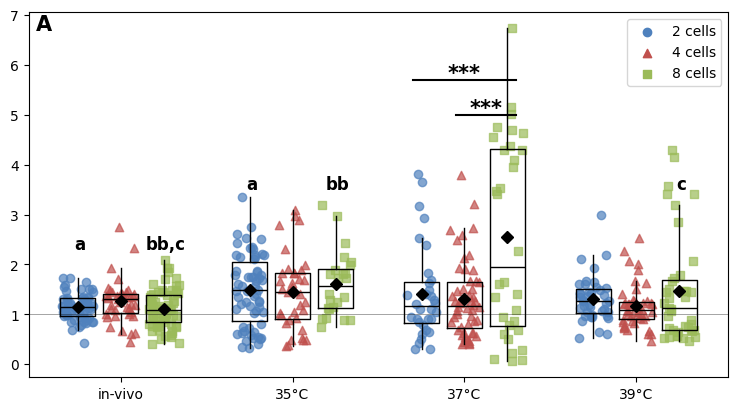

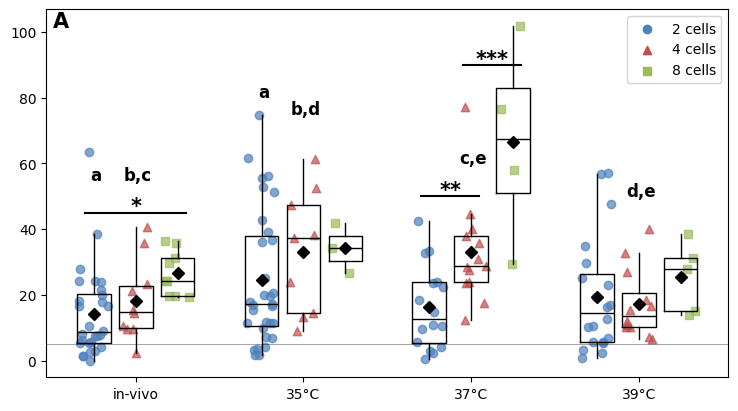

In [198]:
plot_FIG10_5mC_PI_ratio_v1(ivf_embryo_methylation_v0,)

print("clipboarding fig10_for_anova")

for_anova = hook['fig10_for_anova']
data_col = 'ratio'
_df_to_clip(for_anova, sep="\t", float_format="%.4f", index=False) 
anova = stats_anova2w(for_anova, 'Group', 'Ncells', data_col)
_df_to_clip(anova, sep="\t", float_format="%.4f") 
lsd = stats_fisher_lsd(anova, for_anova, 'Group', 'Ncells', data_col)
_df_to_clip(lsd.astype(float), sep="\t", float_format="%.4f")
lsd_pv = stat_2d_pval_table_to_sparse(lsd)
l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[0] == idx[2]) or (idx[1] == idx[3])]
l = pd.DataFrame(l, columns=['g1', 'g2', 'g1', 'g2', 'pvalue'])
l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
_df_to_clip(l, sep="\t", float_format="%.4f", index=False)


plot_FIG10b_5mC_PI_ratio_CV_v1(ivf_embryo_methylation_v0)

print("clipboarding fig10b_for_anova")

for_anova = hook['fig10b_for_anova']
data_col = 'cv'
_df_to_clip(for_anova, sep="\t", float_format="%.4f", index=False) 
anova = stats_anova2w(for_anova, 'Group', 'Ncells', data_col)
_df_to_clip(anova, sep="\t", float_format="%.4f") 
lsd = stats_fisher_lsd(anova, for_anova, 'Group', 'Ncells', data_col)
_df_to_clip(lsd.astype(float), sep="\t", float_format="%.4f")
lsd_pv = stat_2d_pval_table_to_sparse(lsd)
l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[0] == idx[2]) or (idx[1] == idx[3])]
l = pd.DataFrame(l, columns=['g1', 'g2', 'g1', 'g2', 'pvalue'])
l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
_df_to_clip(l, sep="\t", float_format="%.4f", index=False)

## embryo wb v1

In [7]:
ENV.update(
    axw=2.5,
    axh=3,
    gridkw=dict(wspace=0.1),
    letpos=(0.02, 0.92),
    do_axlabels=True,
)

In [8]:
pregnancy_offspring_v0 = ckpt_fn_pregnancy_offspring_v0("../data_src")
blastulation_times_areas_v0 = ckpt_fn_blastulation_times_areas_v0("../data_src/Эмбр_деления вся дата(фин).csv")
pronucleus_fusion_v0 = ckpt_fn_pronucleus_fusion_v0("../data_src/Слияние пронуклеусов (добавлено АЛИЯ) (1).csv")
ivf_embryo_methylation_v0 = ckpt_fn_ivf_embryo_methylation_v0()
embryo_cell_mass_v0 = ckpt_fn_embryo_cell_mass_v0("../data_src")

In [9]:
%run -i ./framework_embryo_v1.py

g  d  g  d        pvalue stars
0  2  2  1  2  6.285910e-04   ***
1  2  4  1  4  2.287829e-06   ***
2  2  8  1  8  3.177758e-03    **
3  3  2  1  2  9.547918e-14   ***
4  3  2  2  2  1.836512e-05   ***
5  3  4  1  4  1.375930e-09   ***
6  0  4  1  4  3.080223e-08   ***
7  0  8  1  8  5.512479e-04   ***
8  0  8  3  8  1.108160e-02     *

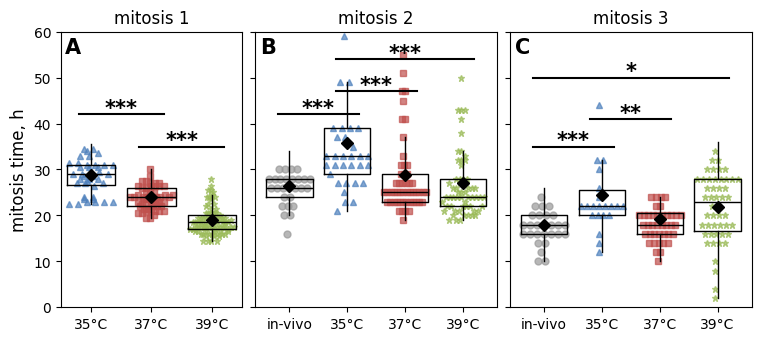

In [14]:
plot_FIG2_embryo_division_times_v1(blastulation_times_areas_v0, pronucleus_fusion_v0, opts=None)
for_anova = hook['FIG2_for_anova']
anova = stats_anova2w(for_anova, 'g', 'd', 't')
lsd = stats_fisher_lsd(anova, for_anova, 'g', 'd', 't')
lsd_pv = stat_2d_pval_table_to_sparse(lsd)
# display(lsd_pv)
l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[1] == idx[3])]
l = pd.DataFrame(l, columns=['g', 'd', 'g', 'd', 'pvalue'])
l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
l

phony save #=PHONY=#/FIG3_embryo_dead_alive_div_time_v0.svg


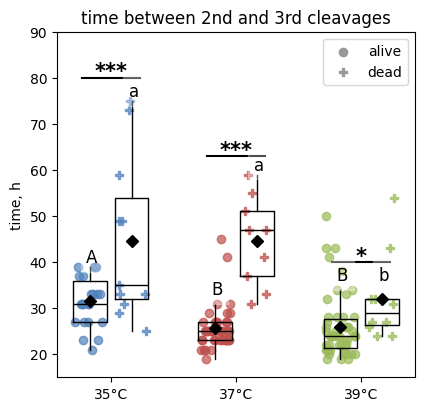

In [259]:
plot_FIG3_embryo_dead_alive_div_time_v0(blastulation_times_areas_v0, opts=opts) 

In [241]:
%run -i framework_embryo_v1.py

phony save #=PHONY=#/FIG3_embryo_dead_alive_div_time_v1.svg


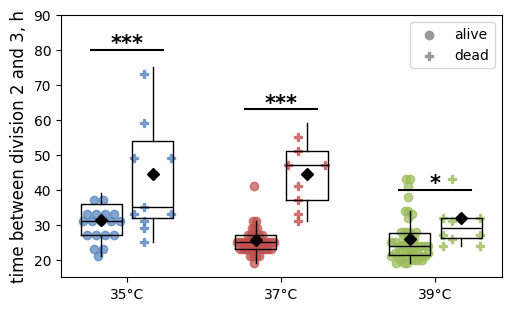

In [242]:
plot_FIG3_embryo_dead_alive_div_time_v1(blastulation_times_areas_v0, opts=opts)

phony save #=PHONY=#/FIG4_blastomere_areas_v1.svg


g  d  g  d        pvalue stars
0  1  2  0  2  1.753513e-04   ***
1  1  4  0  4  9.489141e-03    **
2  2  2  1  2  2.752709e-06   ***
3  2  4  1  4  1.832908e-02     *
4  3  2  1  2  7.857346e-07   ***

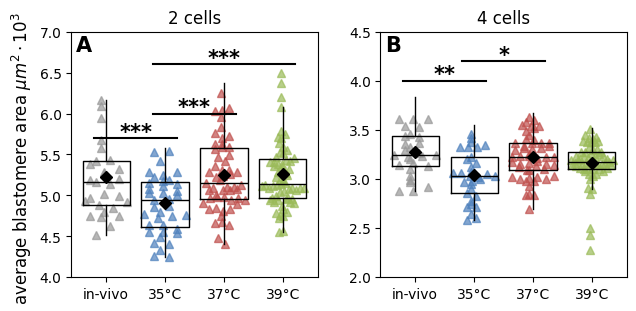

In [306]:
plot_FIG4_blastomere_areas_v1(blastulation_times_areas_v0, opts=opts)
for_anova = hook["FIG4_for_anova"]
anova = stats_anova2w(for_anova, 'group', 'div', 'means')
lsd = stats_fisher_lsd(anova, for_anova, 'group', 'div', 'means')
lsd_pv = stat_2d_pval_table_to_sparse(lsd)
# display(lsd_pv)
l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[1] == idx[3])]
l = pd.DataFrame(l, columns=['g', 'd', 'g', 'd', 'pvalue'])
l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
l

phony save #=PHONY=#/FIG10_5mC_PI_ratio_v2.svg
phony save #=PHONY=#/FIG10b_5mC_PI_ratio_CV_v2.svg


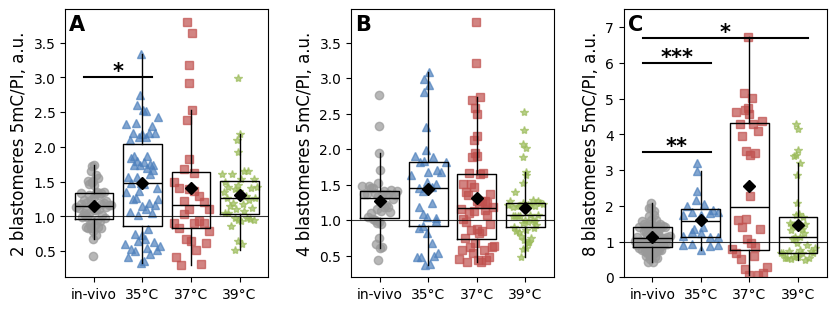

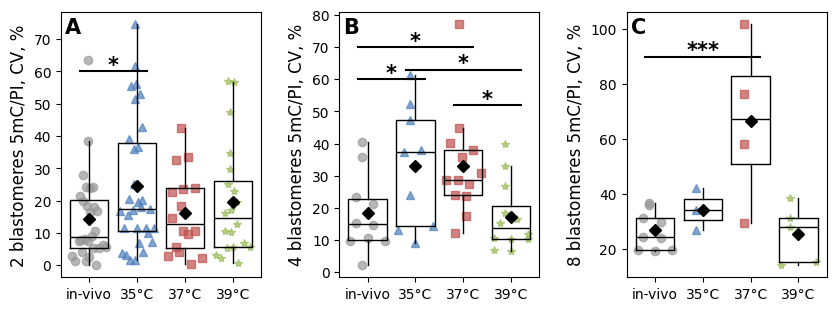

In [202]:
plot_FIG10_5mC_PI_ratio_v2(ivf_embryo_methylation_v0, opts=opts)
plot_FIG10b_5mC_PI_ratio_CV_v2(ivf_embryo_methylation_v0, opts=opts)

phony save #=PHONY=#/FIG9_cell_mass_distribution_v2.svg


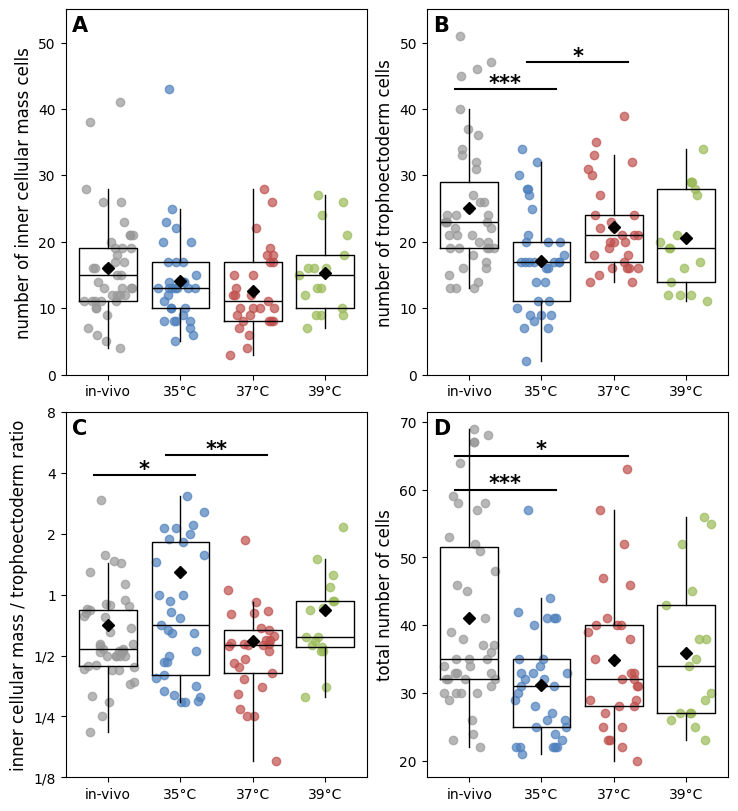

In [206]:
plot_FIG9_cell_mass_distribution_v2(embryo_cell_mass_v0, opts=opts)

phony save #=PHONY=#/FIG9_cell_mass_distribution_v3.svg


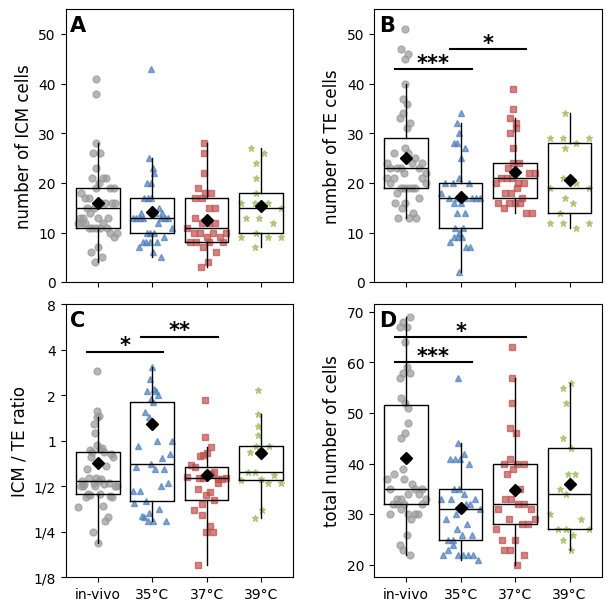

In [229]:
plot_FIG9_cell_mass_distribution_v3(embryo_cell_mass_v0, opts=opts)

In [245]:
_, tbls = ckpt_table_ckpt_v0(Path(".."))

In [32]:
hook = {}
%run -i ./framework.py
%run -i ./framework_embryo.py
%run -i ./framework_embryo_v1.py

def plotwb_embryos_v1():
    fn = get_caller()
    d = fn.__name__.removeprefix("plotwb_")
    outd = Path(f"../workbooks/{d}").resolve()
    # if reset_dir and outd.exists(): shutil.rmtree(outd)
    outd.mkdir(exist_ok=True, parents=True)
    desc_p = Path(f"../text/plotwb_descr-{d}.md")

    opts = {
        "group_colors": ["#999999", "#4f81bd", "#c0504d", "#9bbb59"],
        "letters": plt_add_letters(LETTERS_EN),
        "lang": LANG_EN,
        'outd': outd,
        'figsave': plt_figsave_svg_png_300dpi,
        'extra_letters': True,
        'do_axlabels': True,
    }
    opts = dct_diff_update(opts, ENV)

    src_dir="../data_src"
    pregnancy_offspring_v0 = ckpt_fn_pregnancy_offspring_v0(src_dir)
    blastulation_times_areas_v0 = ckpt_fn_blastulation_times_areas_v0(f"{src_dir}/Эмбр_деления вся дата(фин).csv")
    pronucleus_fusion_v0 = ckpt_fn_pronucleus_fusion_v0(f"{src_dir}/Слияние пронуклеусов (добавлено АЛИЯ) (1).csv")
    embryo_cell_mass_v0 = ckpt_fn_embryo_cell_mass_v0(src_dir)
    ivf_embryo_methylation_v0 = ckpt_fn_ivf_embryo_methylation_v0()
    
    def plot(opts):
        plot_FIG1_embryos_survival_v1(blastulation_times_areas_v0, opts) # DONE
        plot_FIG2_embryo_division_times_v1(blastulation_times_areas_v0, pronucleus_fusion_v0, opts=opts) # DONE
        plot_FIG3_embryo_dead_alive_div_time_v1(blastulation_times_areas_v0, opts=opts) # DONE
        plot_FIG4_blastomere_areas_v1(blastulation_times_areas_v0, opts=opts) # DONE
        plot_FIG5_blastomere_areas_v1(blastulation_times_areas_v0, opts=opts) # DONE main
        plot_FIG6_blastomere_areas_v1(blastulation_times_areas_v0, opts=opts) # DONE main
        plot_FIG7_blastomere_areas_v1(blastulation_times_areas_v0, opts=opts) # DONE main
        plot_FIG11_implantation_offspring_rates_v1(pregnancy_offspring_v0, opts=opts) # DONE
        plot_FIG9_cell_mass_distribution_v3(embryo_cell_mass_v0, opts=opts) # DONE
        plot_FIG10_5mC_PI_ratio_v2(ivf_embryo_methylation_v0, opts=opts) # DONE
        plot_FIG10b_5mC_PI_ratio_CV_v2(ivf_embryo_methylation_v0, opts=opts) # DONE

    plot(opts)
    outd = outd / "nolabels"
    outd.mkdir(exist_ok=True, parents=True)
    opts.update(outd=outd, do_axlabels=False)
    plot(opts)
    print("DONE!\a")
    
plotwb_embryos_v1()

/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG1_embryos_survival_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG2_embryo_division_times_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG3_embryo_dead_alive_div_time_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG4_blastomere_areas_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG5_blastomere_areas_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG6_blastomere_areas_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG7_blastomere_areas_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG11_implantation_offspring_rates_v1.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG9_cell_mass_distribution_v3.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG10_5mC_PI_ratio_v2.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/FIG10b_5mC_PI_ratio_CV_v2.svg
/home/realdata/lab/ivf2023/workbooks/embryos_v1/nolabels/FIG1_embryos_survival_v1.svg
/home/realdata/lab/ivf2023/workbook

In [15]:
log.maxlevel =1

phony save #=PHONY=#/FIG5_blastomere_areas_v1.svg


df     sum_sq   mean_sq          F    PR(>F)
C(death)             1.0   2.483302  2.483302  13.676939  0.000288
C(group)             3.0   2.577028  0.859009   4.731046  0.003345
C(death):C(group)    3.0   0.801311  0.267104   1.471090  0.223987
Residual           180.0  32.682342  0.181569        NaN       NaN

death  group  death  group    pvalue stars
0      1      2      0      2  0.004365    **

df    sum_sq   mean_sq          F    PR(>F)
C(death)             1.0  1.195038  1.195038  23.403159  0.000003
C(group)             3.0  0.609137  0.203046   3.976365  0.009059
C(death):C(group)    3.0  0.124123  0.041374   0.810256  0.489829
Residual           168.0  8.578600  0.051063        NaN       NaN

death  group  death  group    pvalue stars
0      1      1      0      1  0.019299     *
1      1      2      0      2  0.001884    **

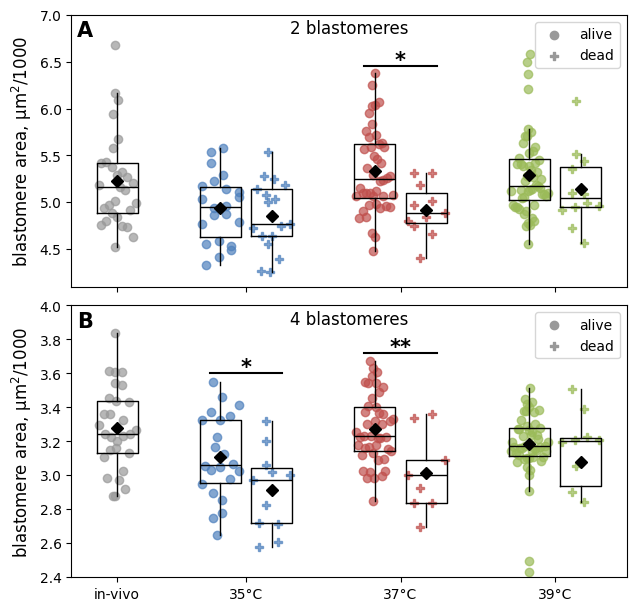

In [31]:
%run -i framework_embryo_v1.py
plot_FIG5_blastomere_areas_v1(blastulation_times_areas_v0, opts=None)
for_anova_g = hook['FIG5_for_anova']
for div in [1, 2]:
    for_anova = report.splitby(for_anova_g, 'div')[div]
    c1, c2, dat = 'death', 'group', 'area'
    anova = stats_anova2w(for_anova, c1, c2, dat)
    display(anova)
    lsd = stats_fisher_lsd(anova, for_anova, c1, c2, dat)
    lsd_pv = stat_2d_pval_table_to_sparse(lsd)
    l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[1] == idx[3])]
    l = pd.DataFrame(l, columns=[c1, c2, c1, c2, 'pvalue'])
    l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
    display(l)

phony save #=PHONY=#/FIG7_blastomere_areas_v1.svg


df        sum_sq     mean_sq         F    PR(>F)
C(death)             1.0    172.173329  172.173329  3.005970  0.084671
C(group)             3.0    353.108190  117.702730  2.054969  0.107856
C(death):C(group)    3.0    408.589098  136.196366  2.377849  0.071417
Residual           180.0  10309.883740   57.277132       NaN       NaN

Empty DataFrame
Columns: [death, group, death, group, pvalue, stars]
Index: []

df       sum_sq     mean_sq         F    PR(>F)
C(death)             1.0   322.795112  322.795112  5.916232  0.016052
C(group)             3.0   304.458695  101.486232  1.860053  0.138296
C(death):C(group)    3.0   543.871515  181.290505  3.322717  0.021177
Residual           168.0  9166.235922   54.560928       NaN       NaN

death  group  death  group   pvalue stars
0      1      2      0      2  0.00024   ***

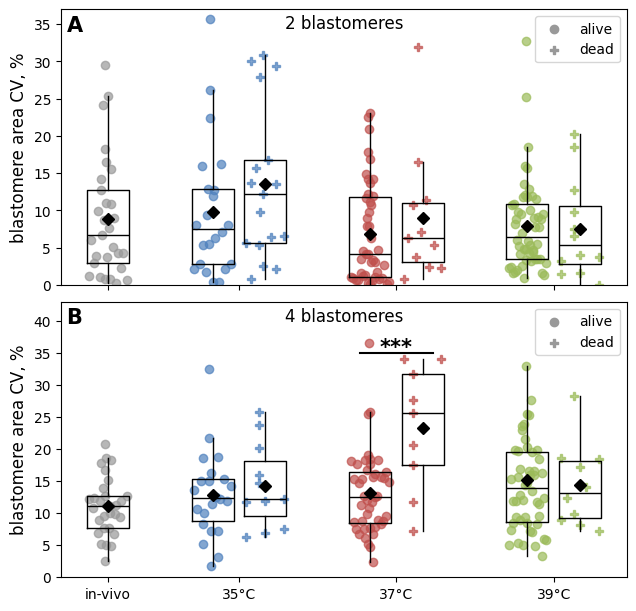

In [25]:
%run -i framework_embryo_v1.py
plot_FIG7_blastomere_areas_v1(blastulation_times_areas_v0, opts=None)
for_anova_g = hook['FIG7_for_anova']
for div in [1, 2]:
    for_anova = report.splitby(for_anova_g, 'div')[div]
    c1, c2, dat = 'death', 'group', 'areacv'
    anova = stats_anova2w(for_anova, c1, c2, dat)
    display(anova)
    lsd = stats_fisher_lsd(anova, for_anova, c1, c2, dat)
    lsd_pv = stat_2d_pval_table_to_sparse(lsd)
    l = [[*idx, lsdi] for idx, lsdi in zip(lsd_pv.index, lsd_pv) if (idx[1] == idx[3])]
    l = pd.DataFrame(l, columns=[c1, c2, c1, c2, 'pvalue'])
    l['stars'] = l['pvalue'].map(lambda x: pval_to_int(x)*'*')
    display(l)

# for MMoshkin

In [24]:
%run -i ./framework.py
def plotwb_pls_yscores_v0(reset_dir=False):
    # TODO: FIX COSINOR PLOT (units for vo2, fix y axis)
    # TODO: check units everywhere
    fn = get_caller()
    d = fn.__name__.removeprefix("plotwb_")
    outd = Path(f"../workbooks/{d}").resolve()
    if reset_dir: shutil.rmtree(outd)
    outd.mkdir(exist_ok=True, parents=True)
    opts = {
        'group_colors': ['#40c080', '#f0a040', '#665fd4'],
        'group_labels': ['Контроль', '35°C', '37°C'],
        'groups': [0, 1, 2],
        'outd': outd,
        'figsave': plt_figsave_svg_png_600dpi,
        # 'figsave': plt_figsave_phony,
    }
    pls_source_joint_v0 = ckpt_fn_pls_source_joint_v0("../data_src/")
    plot_pls_yscores_bxp_v0(pls_source_joint_v0, opts=opts)
    plot_pls_behav_corr_w_yscores(pls_source_joint_v0, opts=opts)
    
plotwb_pls_yscores_v0(reset_dir=0)

/home/data/lab/ivf2023/workbooks/pls_yscores_v0/pls_yscores_bxp_v0-y1.svg
/home/data/lab/ivf2023/workbooks/pls_yscores_v0/pls_yscores_bxp_v0-y2.svg
/home/data/lab/ivf2023/workbooks/pls_yscores_v0/pls_behav_corr_w_yscores-y1.svg
/home/data/lab/ivf2023/workbooks/pls_yscores_v0/pls_behav_corr_w_yscores-y2.svg


# TMP

# Trash

phony save /home/data/lab/ivf_time_stats/data_dst/2024-02-06/np/IV.svg


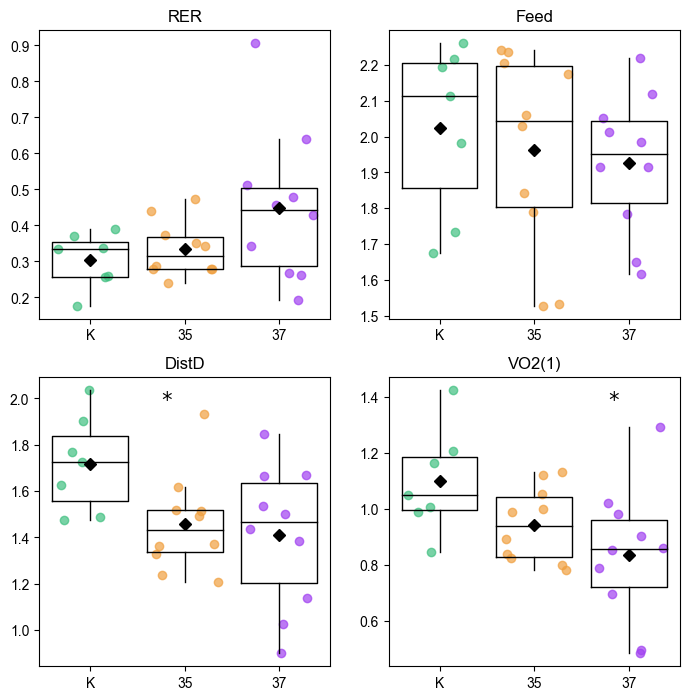

In [84]:
def __plot_npmetric(metric="IV"):
    p = (ENV['outd'] / "np")
    p.mkdir(exist_ok=True)
    figsave = ENV['figsave']
    data_animals = ENV['data_animals']
    groups = ENV['groups']
    
    fig, axs = plt.subplots(2, 2, figsize=(c_A4_w, c_A4_w))
    axs = axs.ravel()
    for i, col in enumerate([cRer, cFeed, cDist, cO2]):
        ax = axs[i]
        t = npm_tbl[col]
        masks = [
            t["animal"].apply(lambda x: x in data_animals[g]).values 
            for g in groups]
        gdata = [t.loc[m, metric].values for m in masks]
        boxplot_main(ax, gdata)
        ax.set_title(col)
    figsave(p/f"{metric}.svg", fig)
__plot_npmetric()

In [ ]:
def _plot_REGRESS_EXAMPLE_report():
#     t = corr_t[(corr_t['c1'] == cFeed) & (corr_t['c2'] == cO2)]    
#     display(t)

    anim = 1
#     color = ENV_colors[0], ENV_colors[2]
    AVG_WINDOW = 6
    HW = AVG_WINDOW // 2
    max_shift = 20
    save_to = ENV_outd / f"REGRESS_EXAMPLE anim={anim}.svg"
    __X_TICKS = ENV_cosinor_time_ticks
    colr1 = ENV_colors[1]
    colr2 = ENV_colors[2]
    
    t1 = t_animal(ts[cDist], anim)
    t2 =   t_animal(ts[cO2], anim)
#     x = t1.X.values
    y1 = t1.Y.values / 100  * 2 # m/h 
    y2 = t2.Y.values
    
    y1a = nonparametric.conv_avg(y1, AVG_WINDOW)
    y2a = nonparametric.conv_avg(y2, AVG_WINDOW)
    
    fig, ax = plt.subplots(1, 1, figsize=(A4_w, 3))
    ax.plot(y1, y2, c=colr1, ls="none", marker="D", markersize=3, alpha=0.5)
    ax.plot(y1a, y2a, c=colr2, ls="none", marker="o", markersize=3, alpha=0.5)
    (bias, weight), __design_mat = dfa.regression_poly(y1, y2)
    (biasa, weighta), __design_mat = dfa.regression_poly(y1a, y2a)
    xr = np.array([0, 160]) 
    yr = xr * weight + bias
    yra = xr * weighta + biasa
    ax.plot(xr, yr, lw=2, c=colr1, label=f"оригинал, O2 = {weight:.2f} * путь + {bias:.0f}")
    ax.plot(xr, yra, lw=2, c=colr2, label=f"сглаженный, O2 = {weighta:.2f} * путь + {biasa:.0f}")
    ax.set_ylim((2000, 4500))
    ax.set_xlim((-10, 190))
#     aspect =  (4500 - 2000) / 90000
    ax.legend(loc="lower right")
#     at = np.arctan2(y2a[1]-y2a[0], xr[1]-xr[0])
#     print(at, at / np.pi * 180)
#     ax.annotate("aaaaaaaaaaaaaaaaaaa", (4000, 3500), rotation=18)
    
#     print(r_squared(y2, y1 * weight+bias))
#     print(r_squared(y2a, y1a * weighta+biasa))
    ENV_letters(ax, (0.005, 0.915))
    ENV_figsave(save_to, fig)
    
    
_plot_REGRESS_EXAMPLE_report()

In [ ]:
def _plot_CORR_TBL_report():
#     t = corr_t[(corr_t['c1'] == cFeed) & (corr_t['c2'] == cO2)]    
#     display(t)
    save_to = ENV_outd / f"CORR_TBL {cDist}vs{cO2} {cFeed}vs{cRer}.svg"
    fig, axs = plt.subplots(1, 2, figsize=(A4_w, 3))
    axs = axs.ravel()
    
    if ENV_lang == LANG_RU:
        lbls = [
            "пройденная дистанция vs\nпотребление О2",
            "съеденный корм vs\nдыхательный коэф."
        ]
        ylbl = "коэф. Пирсона"
    elif ENV_lang == LANG_EN:
        lbls = [
            "distance travelled vs\nO$_2$consumed",
            "food consumed vs\nrespiratory exchange ratio"
        ]
        ylbl = "Pearson coef."
    
    for i, (c1, c2) in enumerate([(cDist, cO2), (cFeed, cRer)]):
        t = corr_t[(corr_t[["c1", "c2"]] == (c1, c2)).all(axis='columns')]
        
        gdata = []
        for group in [0, 1, 2]:
            animals = animals_grouped_good[group]
            d = t[t['anim'].apply(lambda x: x in animals)]
#             gdata.append(d['max_corr_smooth'])
            gdata.append(d['max_corr'])
            
        ax = axs[i]
        lbl = lbls[i]
        boxplot_main(ax, gdata)
        ax.set_title(lbl)
        
    axs[0].set_ylabel(ylbl)
#     axs[0].set_ylim((0.3, 1))
#     axs[1].set_ylim((0.0, 0.4))
    ENV_letters(axs, (0.02, 0.90))
    ENV_figsave(save_to, fig)
    
_plot_CORR_TBL_report()

# histology table

In [369]:
def _make_histology_table(root = None):
    if root is None: root = Path()
    hist_table_dir = root / "ivf_hist/nuclei_measure/2MA"
    save_to = hist_table_dir.parent / (hist_table_dir.name + "_sum_v0.csv")
    rows = []
    for p in hist_table_dir.iterdir():
        name = p.name
        if not name.endswith(".bg.csv"):
            continue
        if "_cortex_" not in name:
            continue
        p1 = hist_table_dir / name.replace(".bg.csv", ".csv")
        parts = name.removesuffix(".bg.csv").split("_")
        
        row = dict(zip(["animal", "p1", "p2"], parts[:-3]))
        row['snap_id'] = parts[-1]    # there can be 4 or 5 parts in the name
        row['region'] = parts[-2]
        row['side'] = parts[-3]
        if parts[0] in ["10r", "10null", "19.1l", "19.1r"]:
            row['group'] = 0
        else:
            row['group'] = 2
        
        bgt = pd.read_csv(p, index_col=0)
        ht = pd.read_csv(p1, index_col=0)
        def __get_channel(x): return ord(x[1]) - 48 # ascii arithmetic 
        bgt["Channel"] = bgt["Label"].map(__get_channel)
        bgt.set_index("Channel", inplace=True)
        ht["Channel"] =  ht["Label"].map(__get_channel)
        ht["Roi"] = ht["Label"].map(lambda x: x[11:])
        ht.set_index(["Channel", "Roi"], inplace=True)
        # while mean brightness is can be heavily influenced by histological artifacts, boundaries and light distribution,
        # median is influenced primarily by the amount of dye and illumination strength / filters etc.
        ht["MeanN"] =  ht["Mean"] / bgt["Median"]
        ht["StdDevN"] = ht["StdDev"] / bgt["Median"]
        
        # count = ht.loc[1, "Area"].count()
        # sum_area = ht.loc[1, "Area"].sum() # though area is not in pixels, while mean/std is calculated accross pixels, it is directly proportionate to pixels
        # sum_signal = (ht["MeanN"] * ht["Area"]).unstack("Channel").sum(axis="index")
        # mean_signal = sum_signal / sum_area
        # _ = np.sqrt((ht["StdDevN"]**2) * ht["Area"])
        # sum_deviation = ((_ + ht["MeanN"] - mean_signal)**2).unstack("Channel").sum(axis="index")
        # mean_deviation = (sum_deviation / sum_area).map(np.sqrt)
        

        r_area, r_mean, r_sd = np_reduce_mean_sd_count(
            ht["Area"].unstack("Channel"), 
            ht["MeanN"].unstack("Channel"), 
            ht["StdDevN"].unstack("Channel"),
            sum_kw=dict(axis="index"),
        )
        # print(r_area, r_mean, r_sd, sep="\n")
        # return
        row["area_mean"] = ht.loc[1, "Area"].mean()
        row["area_sd"] = ht.loc[1, "Area"].std()
        row["cell_count"] = ht.loc[1, "Area"].count()
        row["area_sum"] = r_area.loc[1]
        row.update(zip(["mean_c1", "mean_c2", "mean_c3"], r_mean))
        row.update(zip(["sd_c1", "sd_c2", "sd_c3"], r_sd))
        rows.append(row)
    t = pd.DataFrame(rows)
    # resort
    t = t["snap_id	animal	group	p1	p2	region	side	area_mean	area_sum	area_sd	cell_count	mean_c1	mean_c2	mean_c3	sd_c1	sd_c2	sd_c3".split("\t")]
    t.set_index("snap_id", inplace=True)
    t.to_csv(save_to, sep="\t")
    print(f"saved table to {save_to}")
    return t
hist_t = _make_histology_table()
hist_t

def _aggregate_histology_by_animal(hist_t):
    save_to = Path() / "ivf_hist/nuclei_measure/2MA_sum_v0.csv"
    tg = hist_t.groupby("animal")
    rows = []
    for a in tg.groups:
        gt = tg.get_group(a)
    
        row = dict()
        for i in range(1, 4):
            _ = np_reduce_mean_sd_count(gt["area_sum"], gt[f"mean_c{i}"], gt[f"sd_c{i}"])
            row[f"mean_c{i}"] = _[1]
            row[f"sd_c{i}"] = _[2]
        row["area_sum"] = _[0]
        row["animal"] = a
        row["slice_count"] = len(gt)
        row["group"] = gt["group"].iloc[0]
        row["cell_count"], row["area_mean"], row["area_sd"] = np_reduce_mean_sd_count(gt["cell_count"], gt["area_mean"], gt["area_sd"])
        rows.append(row)
    t2 = pd.DataFrame(rows)
    t2 = t2["animal group slice_count cell_count area_mean area_sd area_sum mean_c1 sd_c1 mean_c2 sd_c2 mean_c3 sd_c3".split()]
    t2.to_csv(save_to, sep="\t")
    return t2
hist_agg = _aggregate_histology_by_animal(hist_t)
hist_agg

saved table to ivf_hist/nuclei_measure/2MA_sum_v0.csv


animal  group  slice_count  cell_count  area_mean    area_sd     area_sum   
0      01l      2           60       17406  68.293224  25.424069  1188711.854  \
1     01lr      2           40       11454  71.192535  26.943020   815439.301   
2      01r      2           60       20095  65.785821  23.996534  1321966.083   
3   02null      2           61       17287  57.458262  20.617111   993280.968   
4      07l      2           60       18838  58.502543  21.695978  1102070.899   
5   07null      2           60       18609  65.502856  25.150700  1218942.652   
6      07r      2           60       15861  59.703058  21.659037   946950.203   
7   10null      0           60       16442  68.135417  24.763405  1120282.528   
8      10r      0          120       36075  60.063327  21.248371  2166784.524   
9    19.1l      0           60       16576  58.685836  20.465595   972776.424   
10   19.1r      0          112       27042  56.506216  21.321355  1528041.094   
11    23lr      2           50       15087  61.394470  25.239116   926258.368   
12  23null      2           56       14677  55.749337  19.968189   818233.024   

     mean_c1     sd_c1   mean_c2     sd_c2   mean_c3     sd_c3  
0   1.278396  0.668486  2.724745  2.370728  5.486062  3.633423  
1   1.099853  0.387560  2.710986  2.664336  4.619185  2.888950  
2   1.156651  0.358283  2.721167  2.709034  4.729992  3.033513  
3   1.001726  0.301709  1.897970  1.311043  4.283847  2.545853  
4   1.084131  0.289342  2.142387  1.263727  5.708320  3.295044  
5   1.286964  0.794078  2.487886  2.694699  5.859528  3.813611  
6   1.397650  0.606756  3.599649  3.430472  4.917507  3.040280  
7   1.487429  0.526386  3.146320  2.386580  3.954970  2.211842  
8   1.232950  0.460566  2.954377  2.732213  4.165452  2.456415  
9   0.980669  0.263126  1.685379  1.196675  3.115614  1.524343  
10  1.216398  0.378841  2.829829  1.967397  3.888227  2.208635  
11  1.350117  0.434442  3.211621  2.205569  5.492405  3.190362  
12  1.089991  0.357641  2.593567  2.188777  4.066046  2.411944

In [362]:
CHANNEL_NAMES_EN = [None, "di-methyl", "acetyl", "DAPI"]

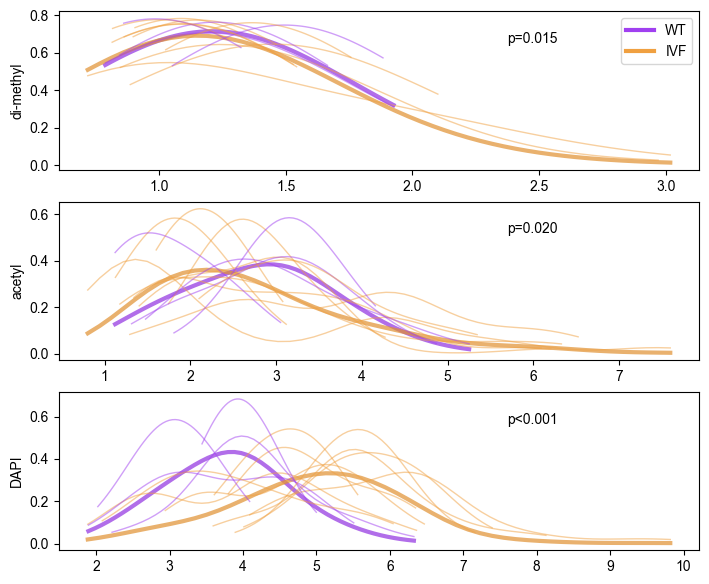

In [376]:
def plot_histology_channel_kde_v0():
    from sklearn.neighbors import KernelDensity

    fig, axs = plt.subplots(3, 1, figsize=(c_A4_w, 7))
    axs = axs.ravel()

    tg = hist_t.groupby("group")
    for ch in range(1, 4):
        ax = axs[ch-1]
        gdata = []
        for g in [0, 2]:
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            gdata.append(xs)
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(xs[:, None])
            xs_pred = np.linspace(xs.min(), xs.max())[:, None]
            ys_pred = np.exp(kde.score_samples(xs_pred))
            # plt.scatter(xs, np.zeros_like(xs), alpha=0.3)
            color = "#9030e0" if gt.iloc[0]["group"]==0 else "#e09030"
            ax.plot(xs_pred, ys_pred, color=color, lw=3, alpha=0.7)
            ax.set_ylabel(f"kde bw=0.5 {ch=}")
        ps = cmp_to_words_2_gr(gdata, ENV['test2'], do_trend=False)[0]
        ax.annotate(ps, (0.7, 0.8), xycoords='axes fraction')
        
    
    tg = hist_t.groupby("animal")
    for ch in range(1, 4):
        ax = axs[ch-1]
        for a in list(tg.groups):
            gt = tg.get_group(a)
            xs = gt[f"mean_c{ch}"].values
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(xs[:, None])
            xs_pred = np.linspace(xs.min(), xs.max())[:, None]
            ys_pred = np.exp(kde.score_samples(xs_pred))
            # plt.scatter(xs, np.zeros_like(xs), alpha=0.3)
            color = "#a040f0" if gt.iloc[0]["group"]==0 else "#f0a040"
            ax.plot(xs_pred, ys_pred, color=color, lw=1, alpha=0.5)
            ax.set_ylabel(f"{CHANNEL_NAMES_EN[ch]}")

    
    axs[0].plot([], [], color="#a040f0", lw=3, label="WT")
    axs[0].plot([], [], color="#f0a040", lw=3, label="IVF")
    axs[0].legend()
    fig.align_ylabels()
    plt.savefig(ENV['outd'] / "hist_kde_v0.svg", bbox_inches="tight")
plot_histology_channel_kde_v0()

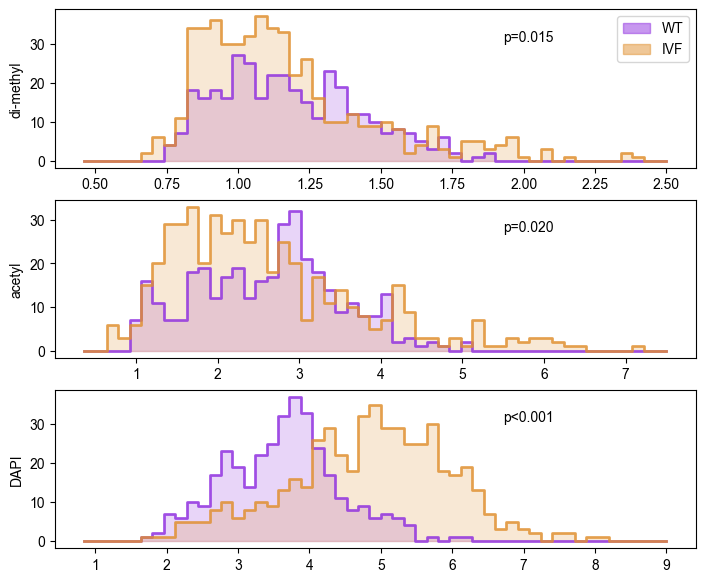

In [377]:
def plot_histology_channel_histogram_v0():
    from sklearn.neighbors import KernelDensity
    
    fig, axs = plt.subplots(3, 1, figsize=(c_A4_w, 7))
    axs = axs.ravel()
    xlims = [(0.5, 2.5), (0.5, 7.5), (1, 9)]

    tg = hist_t.groupby("group")
    for ch in range(1, 4):
        ax = axs[ch-1]
        gdata = []
        xlim = xlims[ch-1]
        for g in [0, 2]:
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            bins = np.linspace(*xlim, num=51, endpoint=True)
            ys, _ = np.histogram(xs, bins)
            ys = np.r_[0, ys, 0]
            xs_m1 =bins[0]- (bins[1] - bins[0])
            bins = np.r_[xs_m1, bins]
            color = "#9030e0" if g==0 else "#e09030"
            ax.step(bins, ys, color=color, lw=2, alpha=0.8)
            ax.fill_between(bins, ys, step="pre", color=color, alpha=0.2)
            gdata.append(xs)
            if ch == 1:
                ax.fill_between([], [], step="pre", color=color, alpha=0.5, label="WT" if g==0 else "IVF")
            
        #     kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(xs[:, None])
        #     xs_pred = np.linspace(xs.min(), xs.max())[:, None]
        #     ys_pred = np.exp(kde.score_samples(xs_pred))
        #     # plt.scatter(xs, np.zeros_like(xs), alpha=0.3)
        #     color = "#9030e0" if gt.iloc[0]["group"]==0 else "#e09030"
        #     ax.plot(xs_pred, ys_pred, color=color, lw=3, alpha=0.7)
        #     ax.set_ylabel(f"kde bw=0.5 {ch=}")
        ps = cmp_to_words_2_gr(gdata, ENV['test2'], do_trend=False)[0]
        ax.annotate(ps, (0.7, 0.8), xycoords='axes fraction')
        ax.set_ylabel(f"{CHANNEL_NAMES_EN[ch]}")
    axs[0].legend()
    plt.savefig(ENV['outd'] / "hist_hist_v0.svg", bbox_inches="tight")
        
plot_histology_channel_histogram_v0()    

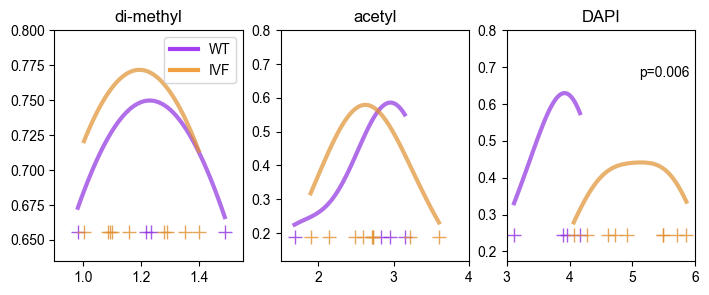

In [413]:
def plot_histology_channel_kde_v0():
    from sklearn.neighbors import KernelDensity
    xlims = [(0.9, 1.55), (1.5, 4), (3, 6)]
    floors = [0.650, 0.20, 0.25]
    fig, axs = plt.subplots(1, 3, figsize=(c_A4_w, 3))
    axs = axs.ravel()
    tg = hist_agg.groupby("group")
    for ch in range(1, 4):
        ax = axs[ch-1]
        gdata = []
        plot_data = []
        for g in [0, 2]:
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            gdata.append(xs)
            gt = tg.get_group(g)
            xs = gt[f"mean_c{ch}"].values
            kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(xs[:, None])
            xs_pred = np.linspace(xs.min(), xs.max())[:, None]
            ys_pred = np.exp(kde.score_samples(xs_pred))
            color = "#9030e0" if gt.iloc[0]["group"]==0 else "#e09030"
            plot_data.append((xs, xs_pred, ys_pred, color))
        _ = np.concatenate((plot_data[0][2], plot_data[1][2]))
        mi, ma = _.min(), _.max() 
        for (xs, xs_pred, ys_pred, color) in plot_data:
            ax.plot(xs, mi * np.ones_like(xs) + 0.1*(mi-ma), ls="none", marker="+", markersize=10, color=color, alpha=0.8)
            ax.plot(xs_pred, ys_pred, color=color, lw=3, alpha=0.7)
            ax.set_title(f"{CHANNEL_NAMES_EN[ch]}")
            ax.set_ylim(mi + 0.3*(mi-ma), 0.8)
            ax.set_xlim(*xlims[ch-1])
        ps = cmp_to_words_2_gr(gdata, ENV['test2'], do_trend=False)[0]
        ax.annotate(ps, (0.7, 0.8), xycoords='axes fraction')
        
    axs[0].plot([], [], color="#a040f0", lw=3, label="WT")
    axs[0].plot([], [], color="#f0a040", lw=3, label="IVF")
    axs[0].legend()
    fig.align_ylabels()
    plt.savefig(ENV['outd'] / "hist_aggregated_kde_v0.svg", bbox_inches="tight")
plot_histology_channel_kde_v0()